In [1]:
import cleaning as cln
import exploring as xpl
import visualizations as vis
import model_comp as mc
import numpy as np
import pandas as pd
import imblearn
import imblearn.over_sampling as imbovr
import seaborn as sb
import os
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image
import sklearnex
from sklearnex import patch_sklearn
patch_sklearn()
import sklearn as skl
import sklearn.model_selection as sklms
import sklearn.compose as sklcmp
import sklearn.linear_model as lm
import sklearn.discriminant_analysis as da
import sklearn.naive_bayes as nb
import sklearn.neighbors as nbr
import sklearn.tree as tree
import sklearn.svm as svm
import xgboost as xgb
import sklearn.feature_selection as sklfs
from sklearn.metrics import confusion_matrix

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# ------ Clean the Data and build Test / Training sets for each Exp
# # creates a df for each experiment, in one list called dfs, from the main() method in cleaning module
pr10_exp1_df, pr10_exp2_df, all_data = cln.main()
dfs = [pr10_exp1_df, pr10_exp2_df, all_data]


In [3]:
def main():
    """Run overarching functions"""
    df = cln.load_data()

    df = cln.clean_data(df)

    cln.add_summary_variables(df)

    exp1, exp2 = cln.create_exp_datasets(df)

    for d in exp1, exp2:
        del d['NotificationDate']

    return exp1, exp2, df


In [4]:
COLS = ("DataNotificacao", "Evolucao", "CriterioConfirmacao", "StatusNotificacao", "FaixaEtaria", "Sexo", "RacaCor",
        "Escolaridade", "Febre", "DificuldadeRespiratoria", "Tosse", "Coriza", "DorGarganta", "Diarreia", "Cefaleia",
        "ComorbidadePulmao", "ComorbidadeCardio", "ComorbidadeRenal", "ComorbidadeDiabetes", "ComorbidadeTabagismo",
        "ComorbidadeObesidade", "FicouInternado", "ViagemBrasil", "ViagemInternacional")

def load_data(filepath_from_script: str = '\data\project_data.csv', cols_to_load: list = COLS):
    """Load data from csv -- only use columns """
    return pd.read_csv(os.path.dirname(os.getcwd()) + filepath_from_script,
                       delimiter=";",
                       encoding='cp1252',
                       usecols=lambda x: x in cols_to_load)  # only loads the required columns from the dataset


In [5]:
def clean_data(data):
    """Prepare data for further analysis"""
    # filter out rows missing required information or not closed
    new_data = filter_df(data)

    # remove StatusNotification column from dataset
    new_data.drop(columns='StatusNotificacao',
                  inplace=True)

    # rename headers and replace commonly used Portuguese words with English for easier analysis and exploration
    replace_portuguese(new_data)

    # set dtypes of columns and add 999 as missing number for integer columns
    set_dtypes(new_data)

    return new_data


In [6]:
def filter_df(data):
    """Remove rows with data that will not help analyses"""
    # only keep rows that are closed and have a final outcome of cured or a death
    new_data = data[
        data['StatusNotificacao'] == 'Encerrado']  # only keep rows that have been marked as close (cured or dead)

    # only keep outcomes marked as cured, COVID death, or other death
    keep_outcomes = ["Cura", 'Óbito por outras causas', 'Óbito pelo COVID-19']
    new_data = new_data[(new_data['Evolucao'].isin(keep_outcomes))]

    return new_data


In [7]:
def replace_portuguese(data):
    """Convert Portuguese to English for easier analysis and exploration"""
    # rename column headers
    data.columns = ['NotificationDate', 'Outcome', 'CriteriaConfirmation', 'AgeGroup', 'Sex', 'ColorRace', 'Education',
                    'Fever', 'BreathingDifficulty', 'Cough', 'RunnyNose', 'SoreThroat', 'Diarrhea', 'Headache',
                    'ComorbidityPulmonary', 'ComorbidityCardiac', 'ComorbidityRenal', 'ComorbidityDiabetes',
                    'ComorbiditySmoking', 'ComorbidityObesity', 'Hospitalized', 'TravelBrasil', 'TravelInternational']

    # replace Portuguese with English words, and No or Yes with 0 or 1
    data.replace(
        {"Não": "No", "Sim": "Yes", "I": "N/A", "-": "N/A", "Ignorado": "N/A", "Não se aplica": "N/A",
         "Não Informado": "N/A", "Cura": 0, "Óbito por outras causas": 1, "Preta": "Black", "Branca": "White", 
         "Parda": "Brown", "Indigena": "Indigenous", "Amarela": "Yellow", "Clinico": "Clinic", "Laboratorial": "Lab", 
         "Clinico Epdemiologico": "Epidem.", "Ensino médio completo (antigo colegial ou 2º grau ) ": "HS",
         "5ª à 8ª série incompleta do EF (antigo ginásio ou 1º grau)": "I Gr. 8",
         "4ª série completa do EF (antigo primário ou 1º grau)": "Gr. 4",
         "Ensino médio incompleto (antigo colegial ou 2º grau )": "I HS",
         "1ª a 4ª série incompleta do EF (antigo primário ou 1º grau)": "I Gr. 4",
         "Educação superior incompleta ": "I Higher", "Educação superior completa": "Higher Ed.",
         "Ensino fundamental completo (antigo ginásio ou 1º grau) ": "Gr. 1", "Analfabeto": "None",
         "Óbito pelo COVID-19": 1, "0 a 4 anos": "0-4", "05 a 9 anos": "5-9", "10 a 19 anos": "10-19", 
         "20 a 29 anos": "20-29", "30 a 39 anos": "30-39", "40 a 49 anos": "40-49", "50 a 59 anos": "50-59", 
         "60 a 69 anos": "60-69", "70 a 79 anos": "70-79", "80 a 89 anos": "80-89", "90 anos ou mais": "90+"},
        inplace=True)
    

In [8]:
def add_summary_variables(data):
    """Add new variables -- sum of comorbidities, sum of symptoms"""

    # create sum of comorbidities and symptoms, and for each, add 1 if the column at that row is equal to 1 (is true)
    sum_true_columns(data,
                     new_col='SumComorbidities',
                     cols_to_sum=['ComorbidityPulmonary', 'ComorbidityCardiac', 'ComorbidityRenal',
                                  'ComorbidityDiabetes', 'ComorbiditySmoking', 'ComorbidityObesity'])

    sum_true_columns(data,
                     new_col='SumSymptoms',
                     cols_to_sum=['Fever', 'BreathingDifficulty', 'Cough', 'RunnyNose',
                                  'SoreThroat', 'Diarrhea', 'Headache'])

    # create new column if first two characters of that row's AgeGroup (as an int) is greater than or equal to 60
    over60_ages = ['60-69', '70-79', '80-89', '90+']
    data['OverSixty'] = np.where(data['AgeGroup'].isin(over60_ages),
                                 "Yes", "No")
    

In [9]:
def sum_true_columns(data, new_col: object, cols_to_sum: list):
    """Adds columns from cols_to_sum that are equal to 1 (i.e. true) and avoids missing values and 0s"""
    data[new_col] = 0
    for i in cols_to_sum:
        data[new_col] += data[i] == "Yes"


In [10]:
def create_exp_datasets(all_data):
    """Split datasets for analyses matching the paper's datasets"""
    # create exp_1
    exp1 = all_data[
        (all_data['NotificationDate'] < "2020-05-24") & (all_data['NotificationDate'] > "2020-02-28")].copy()

    # create exp2 dataset (May 24 - May 31)
    exp2 = all_data[
        (all_data['NotificationDate'] < "2020-06-01") & (all_data['NotificationDate'] > "2020-05-23")].copy()

    return exp1, exp2


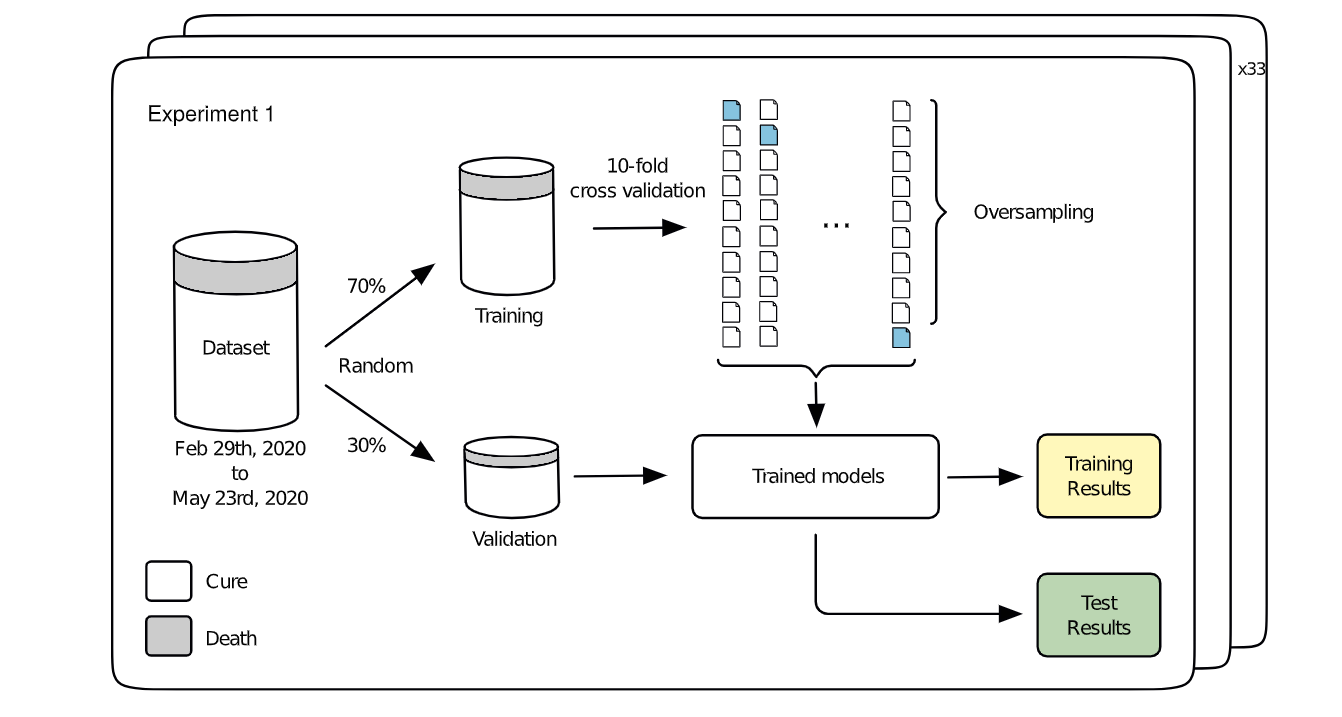

In [2]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\paper_exp1_repr.PNG'))

Now that the data is cleaned and ready, we can get into reproducing the paper's findings...

The paper ran two different experiments, each on data from the same dataset but from separate weeks in early 2020.

In [11]:
def run_exp(models, train_features, train_target, test_features, test_target, evals, rpt: int = 33, focused=False):
    """Train and test the models given the inputs"""
    train_all = []
    test_all = []
    for num in range(rpt):
        train_results = mc.train_models(models, train_features, train_target, evals, focused)

        test_results = mc.test_models(models, train_features, train_target, test_features, test_target, focused)

        train_all.append(train_results)
        test_all.append(test_results)

        print(f'Round {num + 1} completed')

    return [train_all, test_all]


In [12]:
def train_models(models, features, target, evals: list, focused=False):
    """Runs all algos on the given dataset(s) and returns all outputs as a list"""

    outputs = []
    
    for model in models:
        results, target_preds_real = mc.x_validate(model, features, target, evals, focused)
        
        preds, real = target_preds_real
        
        output = {
            'Model': model,
            'Accuracy': np.mean(results['test_accuracy']),
            'ROC AUC': np.mean(results['test_roc_auc']),
            'Average Precision': np.mean(results['test_average_precision']),
            'Precision': np.mean(results['test_precision']),
            'Recall': np.mean(results['test_recall']),
            'F1': np.mean(results['test_f1']),
            'Predictions': preds,
            'Real Outcomes': real
        }
        
        outputs.append(output)

    return outputs


In [13]:
def x_validate(model, features, target, evals: list, focused=False):
    """Run test w/ stratified 10-fold cross-validation"""

    if not focused:
        transformer, oversampler = mc.preprocessing_fns()

    else:
        transformer, oversampler = mc.focused_preprocessing_fns()

    pipeline = imblearn.pipeline.make_pipeline(transformer, oversampler, model)

    pipeline.fit(features, target)

    split_method = sklms.StratifiedKFold(n_splits=10)


    output_all = sklms.cross_validate(estimator=pipeline,
                                                    X=features,
                                                    y=target,
                                                    scoring=evals,
                                                    cv=split_method,
                                                    n_jobs=-1)  # uses multiple processors for training
    print(f'{model} results done')


    target_predictions = sklms.cross_val_predict(estimator=pipeline,
                                                               X=features,
                                                               y=target,
                                                               cv=split_method,
                                                               n_jobs=-1)
    print(f'{model} predicts done')

    target_preds_real = [target_predictions.ravel(), target.values.ravel()]


    return output_all, target_preds_real


In [14]:
def preprocessing_fns():
    """Build pipeline of transformation and oversampling for balancing"""
    categorical_encoder = skl.preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    agegroup_levels = ['0-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
    sumcom_levels = [0, 1, 2, 3, 4, 5, 6]
    sumsym_levels = [0, 1, 2, 3, 4, 5, 6, 7]

    ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1,
                                                       categories=[agegroup_levels, sumcom_levels, sumsym_levels])

    categorical_fts = ['CriteriaConfirmation', 'Sex', 'ColorRace', 'Education', 'Fever',
                       'BreathingDifficulty', 'Cough', 'RunnyNose', 'SoreThroat', 'Diarrhea', 'Headache',
                       'ComorbidityPulmonary', 'ComorbidityCardiac', 'ComorbidityRenal', 'ComorbidityDiabetes',
                       'ComorbiditySmoking', 'ComorbidityObesity', 'Hospitalized', 'TravelBrasil',
                       'TravelInternational', 'OverSixty']
    ordinal_fts = ['AgeGroup', 'SumComorbidities', 'SumSymptoms']
    transformer = sklcmp.make_column_transformer((categorical_encoder, categorical_fts),
                                                 (ordinal_encoder, ordinal_fts))

    oversampler = imbovr.RandomOverSampler(sampling_strategy=1)

    return transformer, oversampler


In [15]:
def test_models(models, train_features, train_target, test_features, test_target, focused):
    """Test the models on the given data"""
    if not focused:
        transformer, oversampler = mc.preprocessing_fns()
    else:
        transformer, oversampler = mc.focused_preprocessing_fns()

    test_results = []

    for model in models:
        pipeline = imblearn.pipeline.make_pipeline(transformer, oversampler, model)

        pipeline.fit(train_features, train_target)

        preds = pipeline.predict(test_features)
        real = test_target.values

        probs = pipeline.predict_proba(test_features)[:, 1]
        precision, recall, _ = skl.metrics.precision_recall_curve(real, probs)

        result = {
            'Model': model,
            'Accuracy': skl.metrics.accuracy_score(real, preds),
            'ROC AUC': skl.metrics.roc_auc_score(real, preds),
            'Average Precision': skl.metrics.average_precision_score(real, probs),
            'Precision': skl.metrics.precision_score(real, preds),
            'Recall': skl.metrics.recall_score(real, preds),
            'F1': skl.metrics.f1_score(real, preds),
            'Predictions': preds,
            'Real Outcomes': real
        }
        test_results.append(result)

    return test_results

In [16]:
# ------- EXP1 ------
# # creates the exp1 train/test datasets
exp1_features = pr10_exp1_df.iloc[:, 1:]
exp1_targets = pr10_exp1_df.iloc[:, 0]
exp1_f_train, exp1_f_test, exp1_t_train, exp1_t_test = mc.train_test_split_strat(
    features=exp1_features,  # features are all columns after the target column
    target=exp1_targets)  # target is first column -- originally 'Outcome'


In [17]:
def train_test_split_strat(features, target, train_size=0.7):
    """Split the data given the parameters"""
    return sklms.train_test_split(features,
                                  target,
                                  train_size=train_size,
                                  stratify=target)


Next up is tuning the hyperparameters for the models to optimize performance...

In [18]:
# # Grid Search to find the best Hyperparameters
params, results = xpl.grid_search([[lm.LogisticRegression(),
                                    [{"model__max_iter": (1000, 1500),
                                      "model__C": (2, 3)}]]],
                                  features=exp1_f_train,
                                  target=exp1_t_train,
                                  eval='roc_auc',
                                  verbose=3)

params


Fitting 10 folds for each of 4 candidates, totalling 40 fits


{'model__C': 2, 'model__max_iter': 1500}

In [20]:
def grid_search(models_and_param_grid, features, target, eval, verbose: int = 0):
    """Test all given parameters to find the best-performing model"""
    for model in models_and_param_grid:
        transformer, oversampler = preprocessing_fns()

        pipeline = imblearn.pipeline.Pipeline(steps=[('transformer', transformer),
                                                        ('oversampler', oversampler),
                                                        ('model', model[0])])

        split_method = sklms.StratifiedKFold(n_splits=10)

        gs = mc.sklms.GridSearchCV(estimator=pipeline,
                                   param_grid=model[1],
                                   scoring=eval,
                                   n_jobs=-1,
                                   cv=split_method,
                                   refit=True,
                                   verbose=verbose)  # allows parameters to be adjusted to see new predictions

        gs.fit(features, target)

        return gs.best_params_, pd.DataFrame(gs.cv_results_)


In [21]:
# set the tuned models to test for the experiments
tuned_models = [
    lm.LogisticRegression(max_iter=1500, C=3.0, fit_intercept=True, tol=1e-05),
    da.LinearDiscriminantAnalysis(store_covariance=True),
    nbr.KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1),
    tree.DecisionTreeClassifier(max_features=None, max_leaf_nodes=10, class_weight='balanced',
                                criterion='log_loss', min_samples_leaf=3),
    xgb.XGBClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000, subsample=0.6),
    svm.SVC(kernel='rbf', C=10, gamma=0.0001, probability=True)
]


The authors repeated the first experiment 33x and took the average of the results.

Given it takes over 10 hours to run (on my laptop), I changed it to only run 1x in this notebook so it would finish. In the repository, I have figures saved from when I ran the experiment 33x.

In [22]:
# Run Experiment 1 and create Training and Test Results
all_exp1_dfs = run_exp(tuned_models,
                       train_features=exp1_f_train,
                       train_target=exp1_t_train,
                       test_features=exp1_f_test,
                       test_target=exp1_t_test,
                       evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
                       rpt=1)

# Get means of test results for each run
exp1_train_means, exp1_test_means = mc.lists_of_runs_to_lists_of_model_means(all_exp1_dfs)


LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) results done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) predicts done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) is completed
LinearDiscriminantAnalysis(store_covariance=True) results done
LinearDiscriminantAnalysis(store_covariance=True) predicts done
LinearDiscriminantAnalysis(store_covariance=True) is completed
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) results done
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) predicts done
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) is completed
DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_leaf_nodes=10, min_samples_leaf=3) results done
DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_leaf_nodes=10, min_samples_leaf=3) predicts done
DecisionTreeClassifier(class_weight='balanced', crit

In [23]:
def lists_of_runs_to_lists_of_model_means(all_dfs: list):
    """Convert list of dictionaries of each run into one list of dictionaries of average results for each model"""
    all_mean_results = []
    for data in all_dfs:
        data_by_model = []
        run_num = 0

        for run in data:
            run_num += 1
            for new_model_run in run:
                if new_model_run.get('Model') in [model_runs.get('Model') for model_runs in data_by_model]:
                    for existing in data_by_model:
                        if new_model_run.get('Model') == existing.get('Model'):
                            for key in existing.keys():
                                if key not in ('Model', 'Predictions', 'Real Outcomes'):
                                    existing[key] += new_model_run[key]
                            for key in ('Predictions', 'Real Outcomes'):
                                existing[key] = np.append(existing[key], new_model_run[key])
                else:
                    data_by_model.append(new_model_run)

        # divide by number of runs
        for model in data_by_model:
            for key in model.keys():
                if key not in ('Model', 'Predictions', 'Real Outcomes'):
                    model[key] = model[key] / run_num

        all_mean_results.append(data_by_model)

    return all_mean_results


The second experiment followed a nearly-identical process to the first experiment. However, it compared temporally-different data and it ran only 1x instead of 33x.

In [24]:
# -------- EXP2 -------
# creates the exp2 train/test datasets
exp2_f_train = pr10_exp1_df.iloc[:, 1:]
exp2_t_train = pr10_exp1_df.iloc[:, 0]
exp2_f_test = pr10_exp2_df.iloc[:, 1:]
exp2_t_test = pr10_exp2_df.iloc[:, 0]


In [25]:
# Run Experiment 2 and create Training and Test Results
all_exp2_dfs = run_exp(tuned_models,
                       exp2_f_train,
                       exp2_t_train,
                       exp2_f_test,
                       exp2_t_test,
                       evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
                       rpt=1)

# Get means of test results for each run
exp2_train_means, exp2_test_means = lists_of_runs_to_lists_of_model_means(all_exp2_dfs)


LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) results done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) predicts done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) is completed
LinearDiscriminantAnalysis(store_covariance=True) results done
LinearDiscriminantAnalysis(store_covariance=True) predicts done
LinearDiscriminantAnalysis(store_covariance=True) is completed
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) results done
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) predicts done
KNeighborsClassifier(algorithm='kd_tree', leaf_size=10, n_neighbors=10, p=1) is completed
DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_leaf_nodes=10, min_samples_leaf=3) results done
DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_leaf_nodes=10, min_samples_leaf=3) predicts done
DecisionTreeClassifier(class_weight='balanced', crit

Next step is building the visualizations to analyse demographics and compare models.

In [26]:
# set display theme to basic seaborn
plt.ioff()
sb.set_theme()

# set figure directory
figure_path = os.path.dirname(os.getcwd()) + "\\figures"      # for saving files locally


model_shortform = {'LogisticRegression': 'LogReg',
                   'LinearDiscriminantAnalysis': 'LDA',
                   'KNeighborsClassifier': 'KNN',
                   'DecisionTreeClassifier': 'DT',
                   'XGBClassifier': 'XGB',
                   'SVC': 'SVC'}


In [27]:
def histo_bar_plot(df, parameter: str, grouping: str = 'Outcome', axis=None):
    """Create a histogram of counts of each parameter for each group"""
    # set as categorical variable, sorted from highest to lowest count
    df[parameter] = pd.Categorical(df[parameter], categories=df[parameter].value_counts().index)

    # build plot
    plot = sb.countplot(data=df,
                        x=parameter,
                        hue=grouping,
                        ax=axis)

    # make xlabel by adding space before second (or greater) capital letter(s) in parameter name
    xlabel = vis.add_spaces(parameter)

    # remove count from ylabel, set xlabel as the item in xlabels list at same item as current parameter
    plot.set(ylabel=None, xlabel=xlabel)
    

In [28]:
def add_spaces(i):
    """Add spaces before every uppercase letter after the first letter in the word"""
    string = [i[0], ]
    for letter in i[1:]:
        if letter.isupper():
            string.append(f" {letter}")
        else:
            string.append(letter)
    return ''.join(string)


In [29]:
def build_plot_grid(df, parameters: list, grouping: str = 'Outcome', filename: str = 'test', title: str = "", w: int = 3):
    """Build a grid of histogram plots"""
    h = len(parameters) // w if len(parameters) % w == 0 else len(parameters) // w + 1
    figure, grid = plt.subplots(h, 3, figsize=(15, 10))
    figure.suptitle(title)

    row, col = 0, 0

    for var in parameters:
        if not h == 1:
            histo_bar_plot(df, parameter=var, grouping=grouping, axis=grid[row, col])
            if [row, col] != [0, 0]:
                grid[row, col].get_legend().remove()
        else:
            histo_bar_plot(df, parameter=var, grouping=grouping, axis=grid[col])
            if [col] != [0]:
                grid[col].get_legend().remove()

        sum_tick_chars = 0
        for value in df[var].value_counts().index:
            sum_tick_chars += len(str(value))
        if sum_tick_chars > 20:
            plt.setp(grid[row, col].get_xticklabels(), rotation=45,
                     horizontalalignment='right', rotation_mode='anchor')

        if not col == w - 1:
            col += 1
        else:
            col, row = 0, row + 1

        last_col_ind = len(parameters) % w - 1
        if last_col_ind >= 0:
            for i in range(last_col_ind + 1, w):
                if h > 1:
                    grid[h - 1, i].set_axis_off()
                else:
                    grid[i].set_axis_off()

    plt.tight_layout()
    

In [30]:
def build_all_demographics(df, name):
    """Build and show (or save) multiple histogram plot grids"""
    build_plot_grid(df=df,
                    parameters=['CriteriaConfirmation', 'AgeGroup', 'Education', 'ColorRace', 'Sex', 'OverSixty',
                                'Hospitalized', 'TravelBrasil', 'TravelInternational', 'SumSymptoms',
                                'SumComorbidities'],
                    filename=f"{name}_descriptors",
                    title='Descriptors in Training Set')
    
    plt.show()

    build_plot_grid(df=df,
                    parameters=['Fever', 'BreathingDifficulty', 'Cough', 'RunnyNose', 'SoreThroat', 'Diarrhea',
                                'Headache'],
                    filename=f"{name}_symptoms",
                    title='Symptoms in Training Set')
    
    plt.show()

    build_plot_grid(df=df,
                    parameters=['ComorbidityPulmonary', 'ComorbidityCardiac', 'ComorbidityRenal',
                                'ComorbidityDiabetes', 'ComorbiditySmoking', 'ComorbidityObesity'],
                    filename=f"{name}_comorbidities",
                    title='Comorbidities in Training Set')
    
    plt.show()
    

Experiment 1


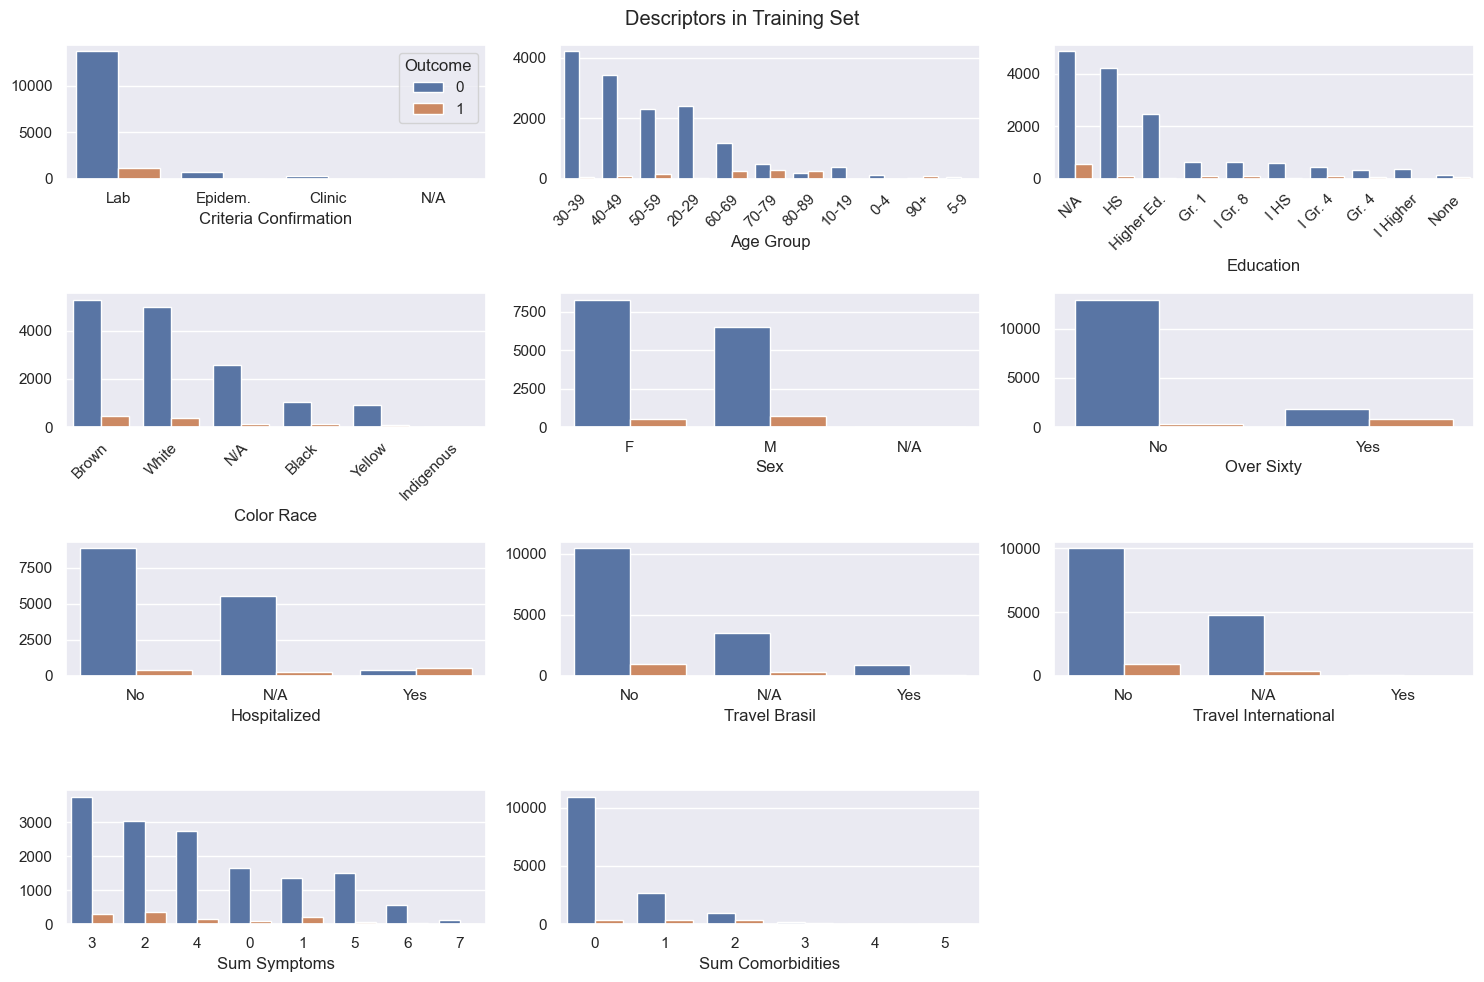

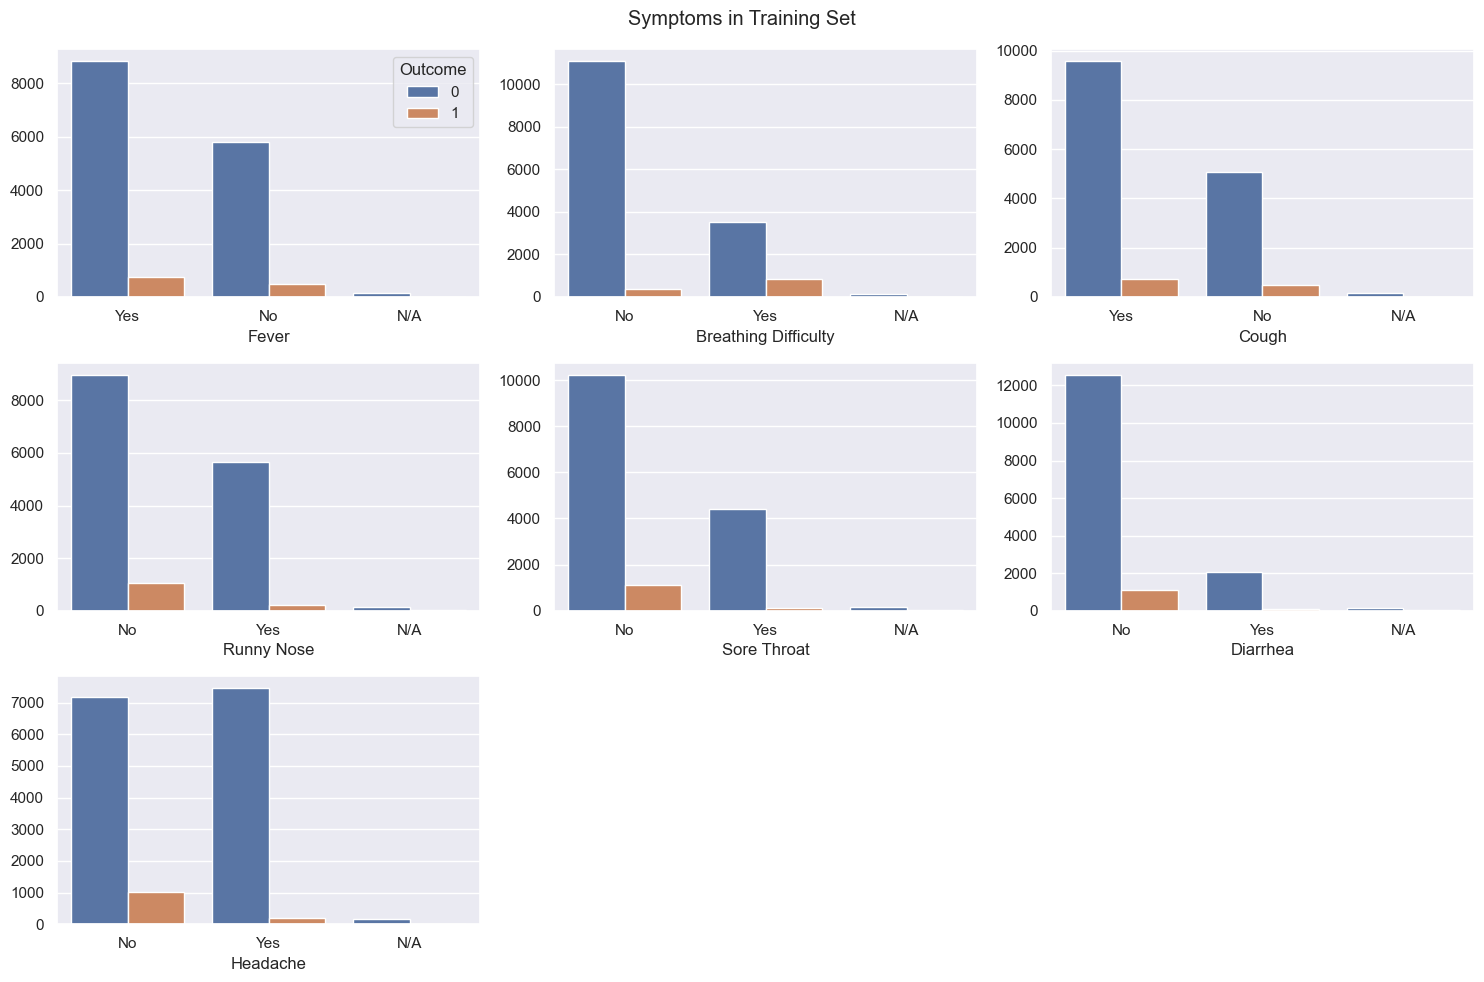

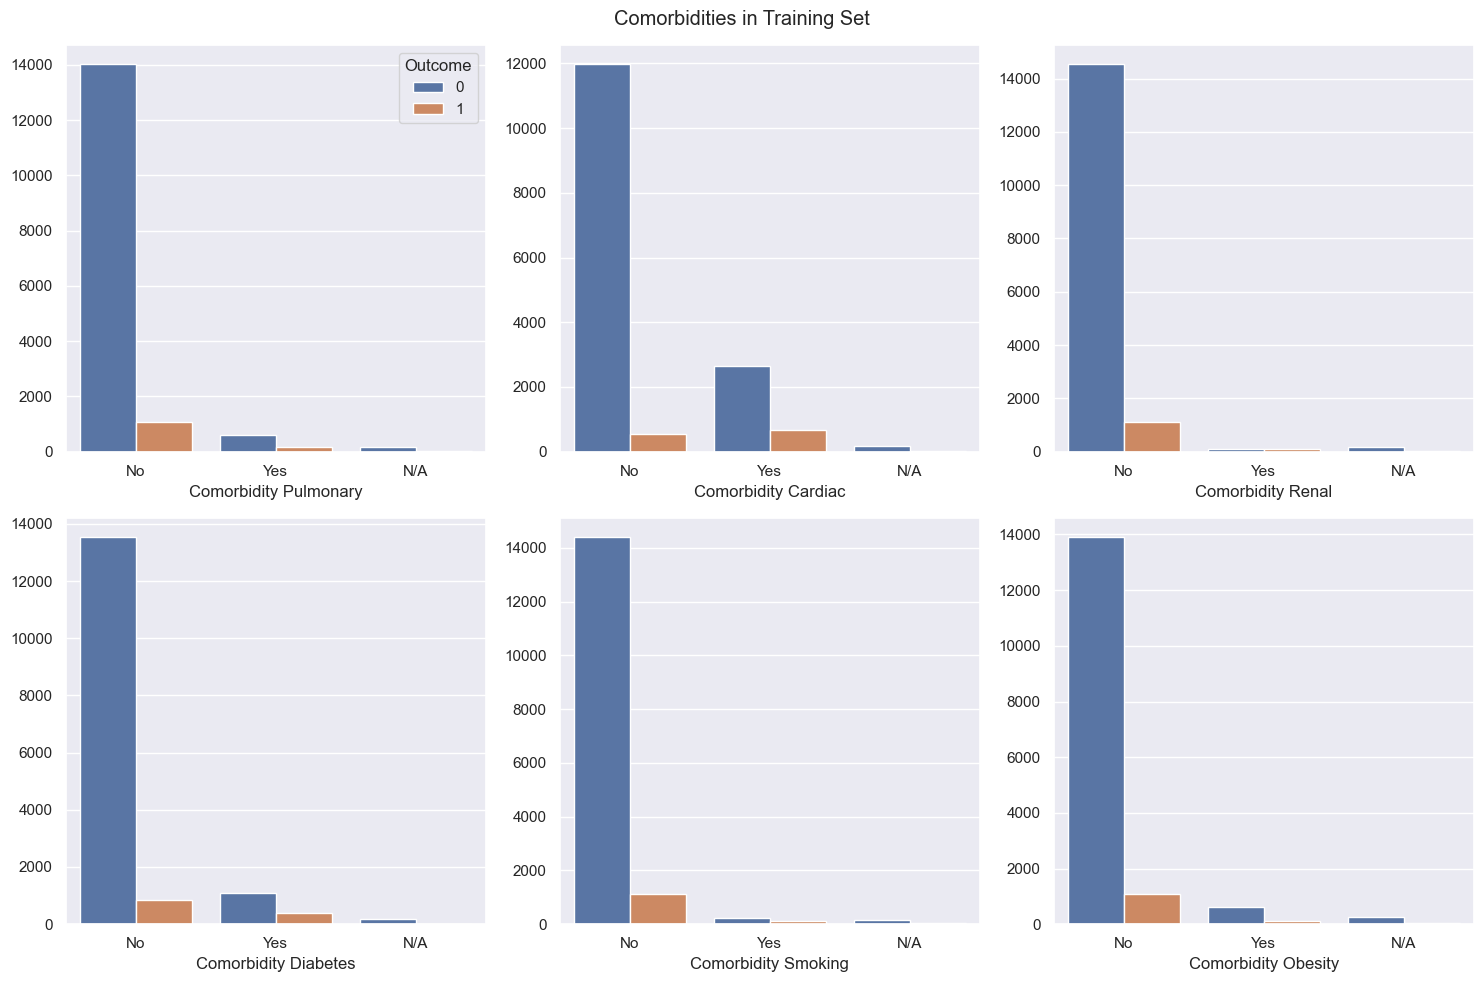



Experiment 2


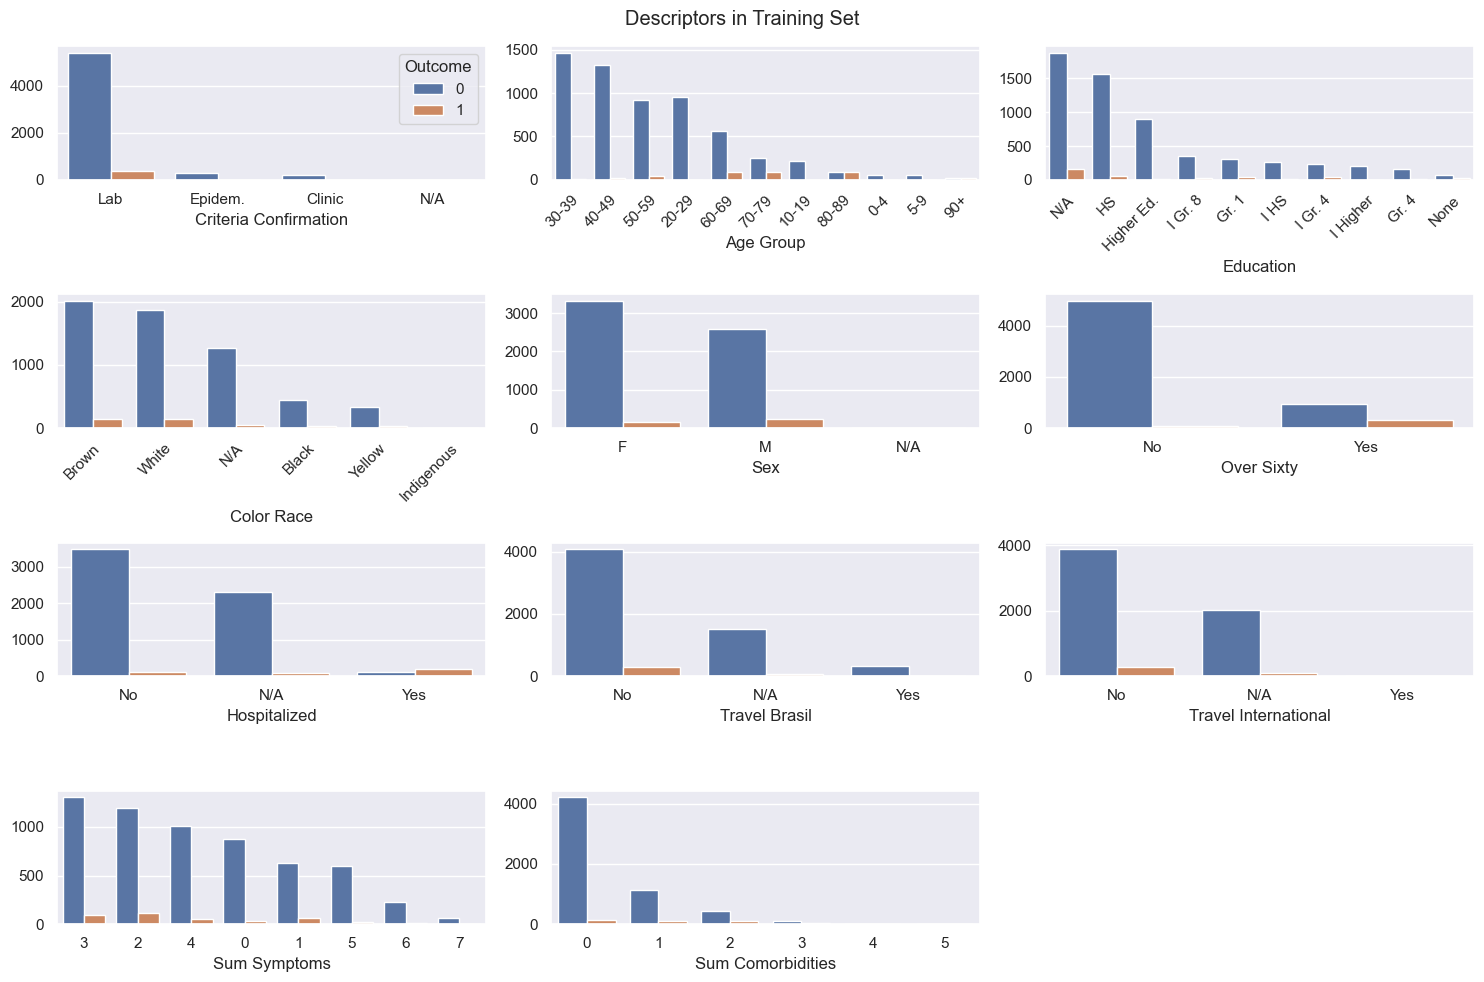

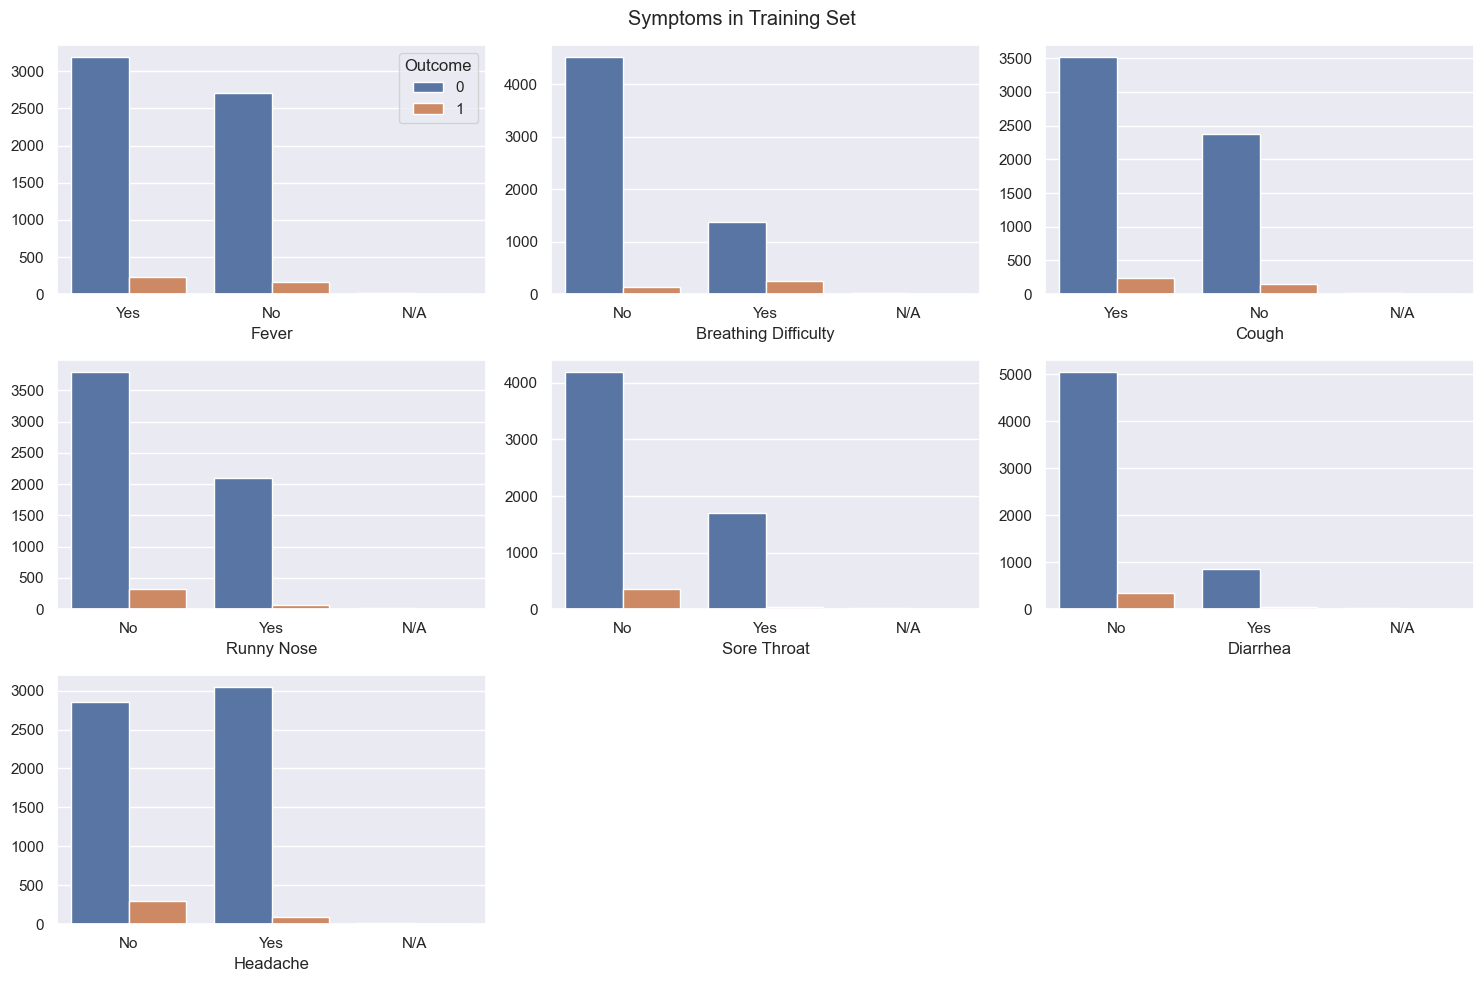

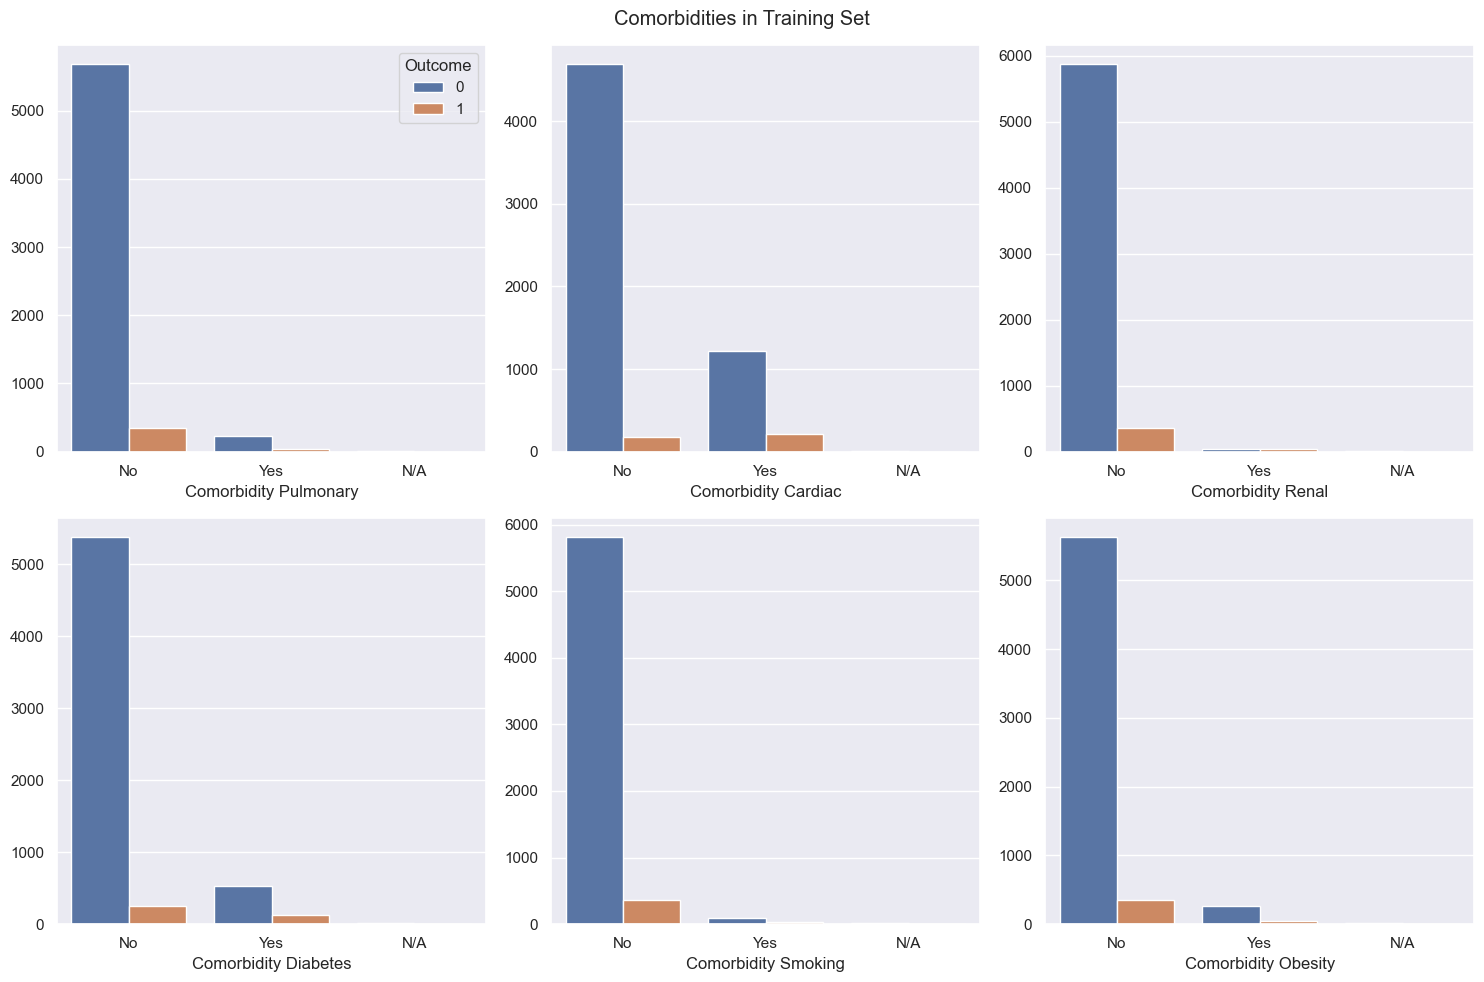

In [31]:
# create and save demographics data for each experiment
data_names = ['Experiment 1', 'Experiment 2']

for data_w_name in zip(dfs, data_names):
    print(data_w_name[1])
    build_all_demographics(data_w_name[0], data_w_name[1])
    print('\n')
    

In [32]:
def create_confusion_matrix_info(data):
    """Prepare real outcomes and predictions data for each model into a format for the confusion matrix"""
    all_models = [type(model).__name__ for model in [d['Model'] for d in data]]
    all_real_and_preds = []
    for d in data:
        real_and_preds = [[], []]
        real_and_preds[0] = d['Real Outcomes']
        real_and_preds[1] = d['Predictions']
        all_real_and_preds.append(real_and_preds)

    return all_models, all_real_and_preds

In [33]:
def build_confusion_matrix(model, real, preds, axis=None):
    """Create a confusion matrix"""
    mtrx = confusion_matrix(real, preds)
    htmp = sb.heatmap(mtrx / np.sum(mtrx), annot=True, fmt='.1%', cmap='Reds', ax=axis)

    htmp.set_xlabel('Predictions')
    htmp.xaxis.set_ticklabels(['Cured', 'Death'])

    htmp.set_ylabel('Real Outcomes')
    htmp.yaxis.set_ticklabels(['Cured', 'Death'])

    htmp.set_title(f'{model}')

In [34]:
def build_conf_mtrx_grid(models: list, all_real_and_preds: list, filename: str, title: str = '', w: int = 3):
    """Make a grid of confusion matrices"""
    h = len(all_real_and_preds) // w if len(all_real_and_preds) % w == 0 else len(all_real_and_preds) // w + 1
    figure, grid = plt.subplots(h, 3, figsize=(15, 8))
    figure.suptitle(title)

    row, col = 0, 0

    for i in range(len(all_real_and_preds)):
        if not h == 1:
            build_confusion_matrix(models[i], all_real_and_preds[i][0], all_real_and_preds[i][1], axis=grid[row, col])

        else:
            build_confusion_matrix(models[i], all_real_and_preds[i][0], all_real_and_preds[i][1], axis=grid[col])

        if not col == w - 1:
            col += 1
        else:
            col, row = 0, row + 1

        last_col_ind = len(all_real_and_preds) % w - 1
        if last_col_ind >= 0:
            for i in range(last_col_ind + 1, w):
                if h > 1:
                    grid[h - 1, i].set_axis_off()
                else:
                    grid[i].set_axis_off()

    plt.tight_layout()
    plt.show()
    

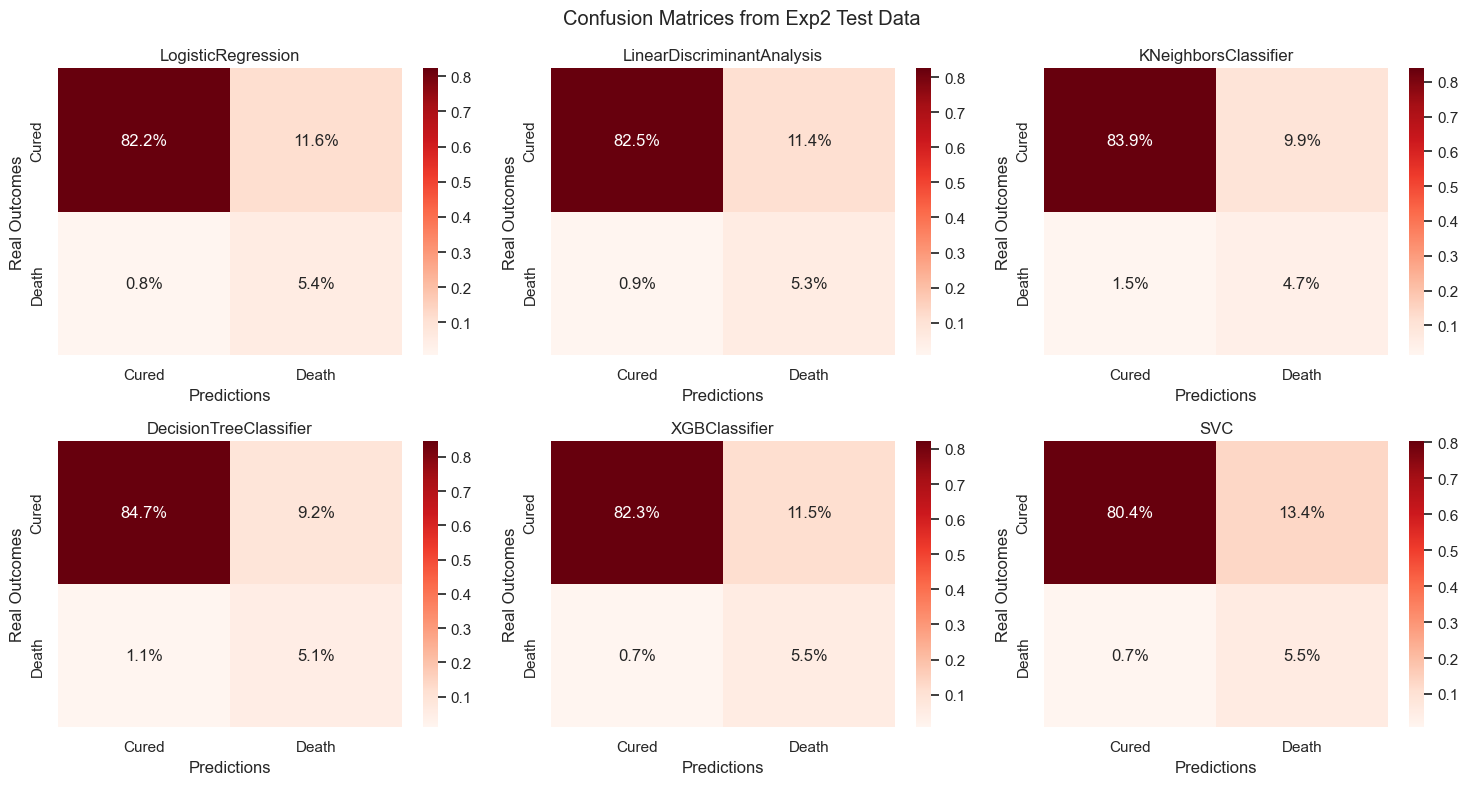

In [35]:
# create correct data format for confusion matrices
all_exp2_test_models, all_exp2_test_real_and_preds = vis.create_confusion_matrix_info(exp2_test_means)

# create grid of confusion matrices
build_conf_mtrx_grid(all_exp2_test_models, all_exp2_test_real_and_preds,
                         filename='conf_mtrx_exp2_test',
                         title='Confusion Matrices from Exp2 Test Data')


And here are the confusion matrices from the second experiment of the paper.

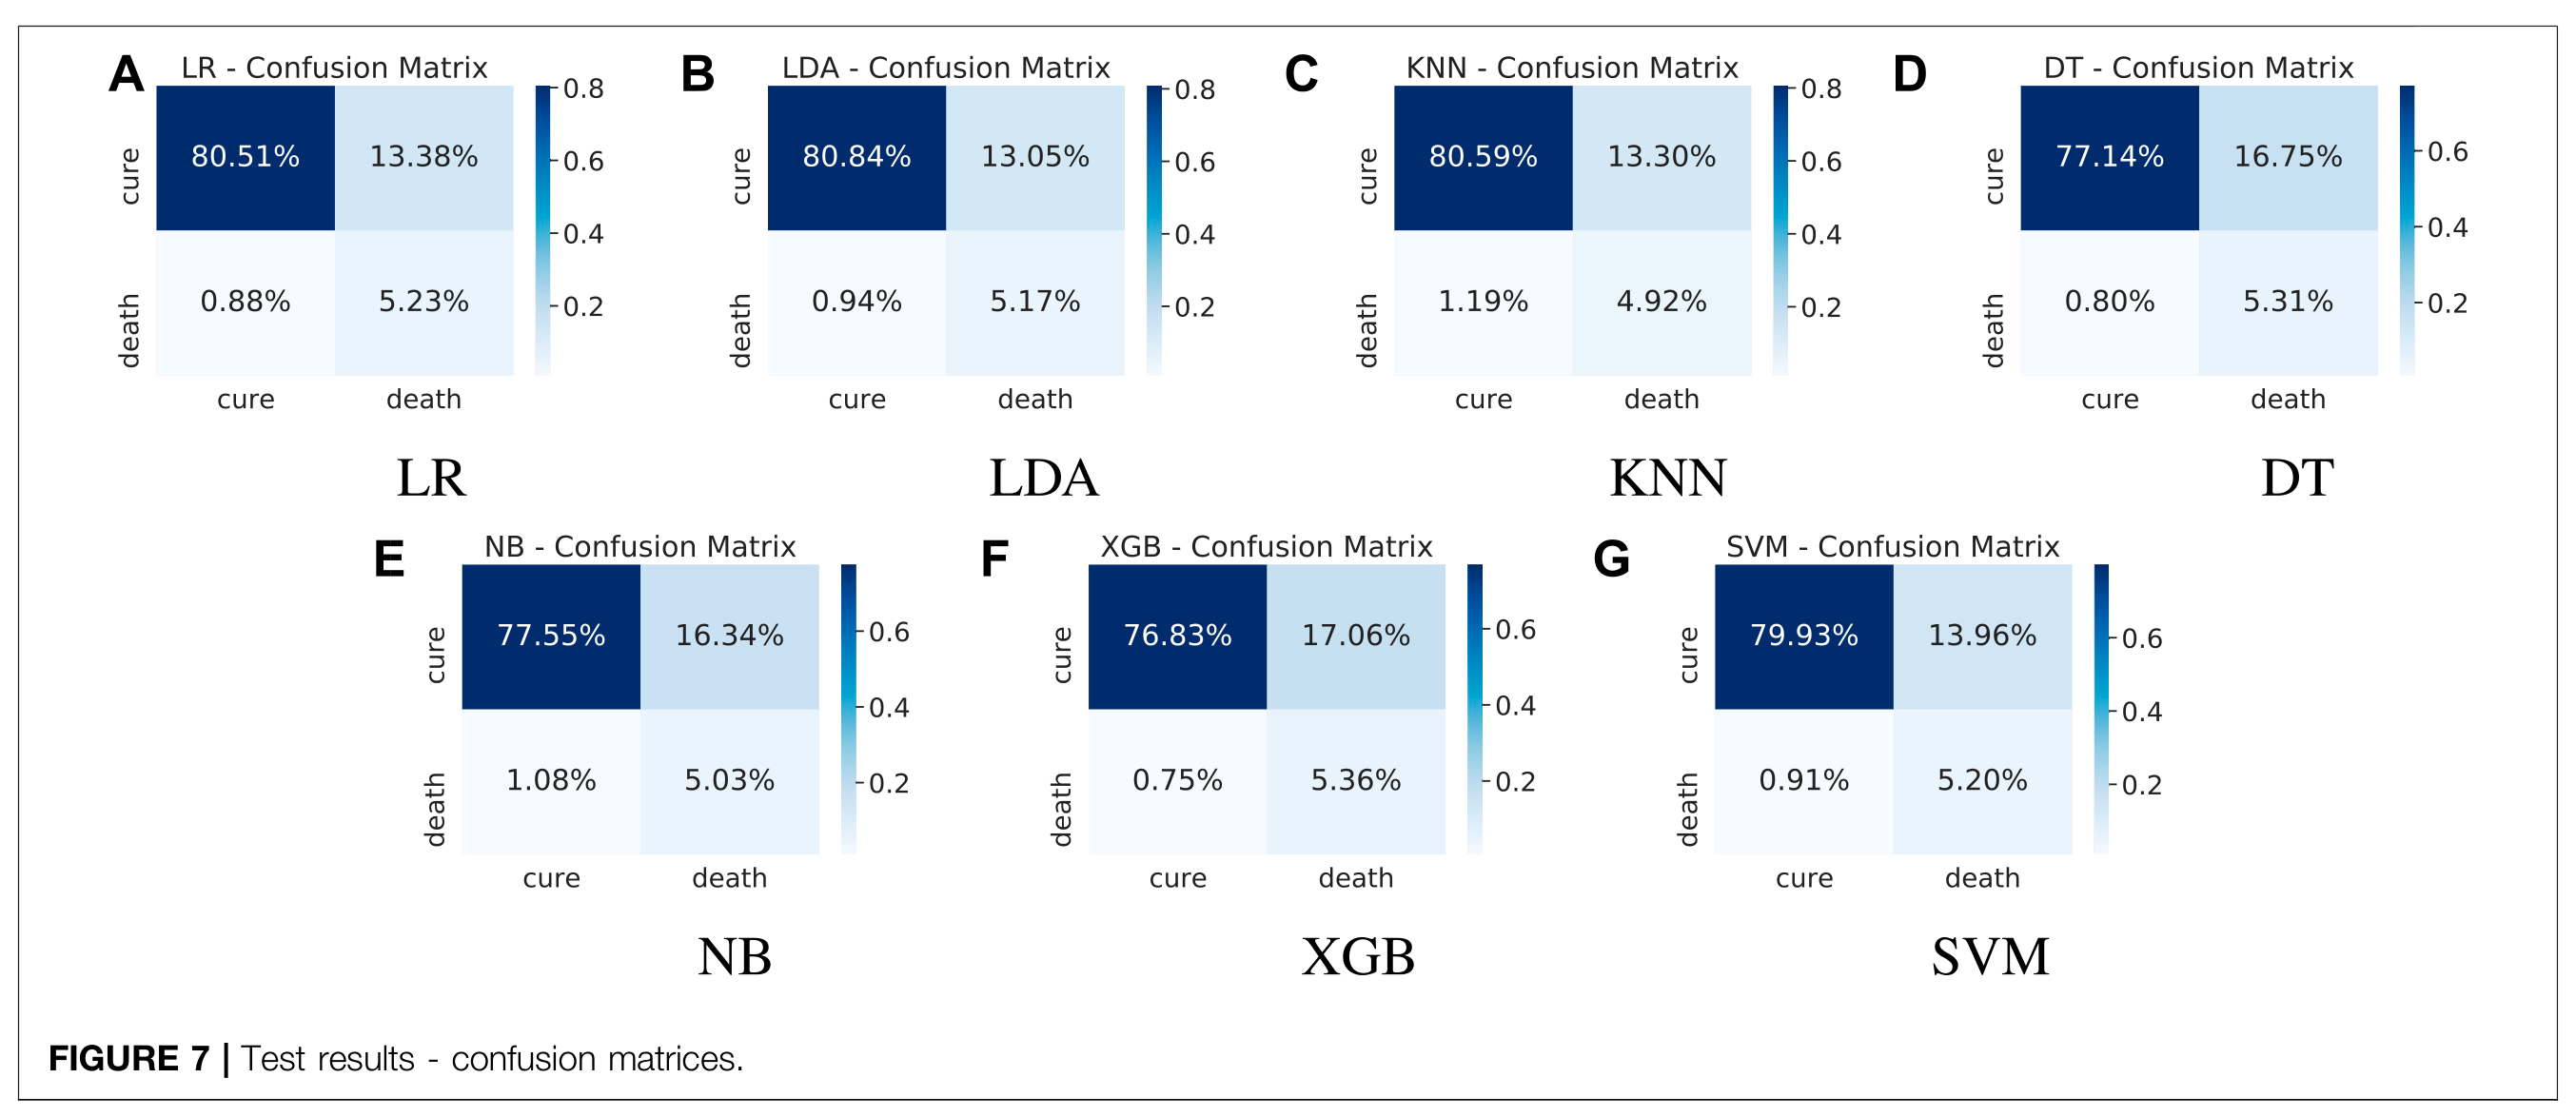

In [4]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\conf_mtrx_paper.PNG'))

In [36]:
def model_metric_bar_plot(data, metric, axis=None):
    """Create a bar plot for a metric of the given models"""
    models = []
    metric_list = []
    for dat in data:
        models.append(model_shortform.get(str(type(dat['Model']).__name__)))
        metric_list.append(dat[metric])

    df = pd.DataFrame(zip(models, metric_list),
                      columns=['Model', metric])

    bp = sb.barplot(x='Model',
                    y=metric,
                    data=df,
                    ax=axis)

    bp.set_ylabel(None)
    bp.set_xlabel(f'Mean {metric}')
    bp.set_ylim(.2, 1)


In [37]:
def model_metric_bar_grid(data, metrics: list, filename: str, title: str='', w: int=3):
    """Create a grid of the metrics for the given models"""
    h = len(metrics) // w if len(metrics) % w == 0 else len(metrics) // w + 1
    figure, grid = plt.subplots(h, 3, figsize=(15, 10))
    figure.suptitle(title)

    row, col = 0, 0

    for i in range(len(metrics)):
        if h > 1:
            model_metric_bar_plot(data, metrics[i], axis=grid[row, col])
        else:
            model_metric_bar_plot(data, metrics[i], axis=grid[col])

        if not col == w - 1:
            col += 1
        else:
            col, row = 0, row + 1

        last_col_ind = len(metrics) % w - 1
        if last_col_ind >= 0:
            for x in range(last_col_ind + 1, w):
                if h > 1:
                    grid[h - 1, x].set_axis_off()
                else:
                    grid[x].set_axis_off()

    plt.tight_layout()


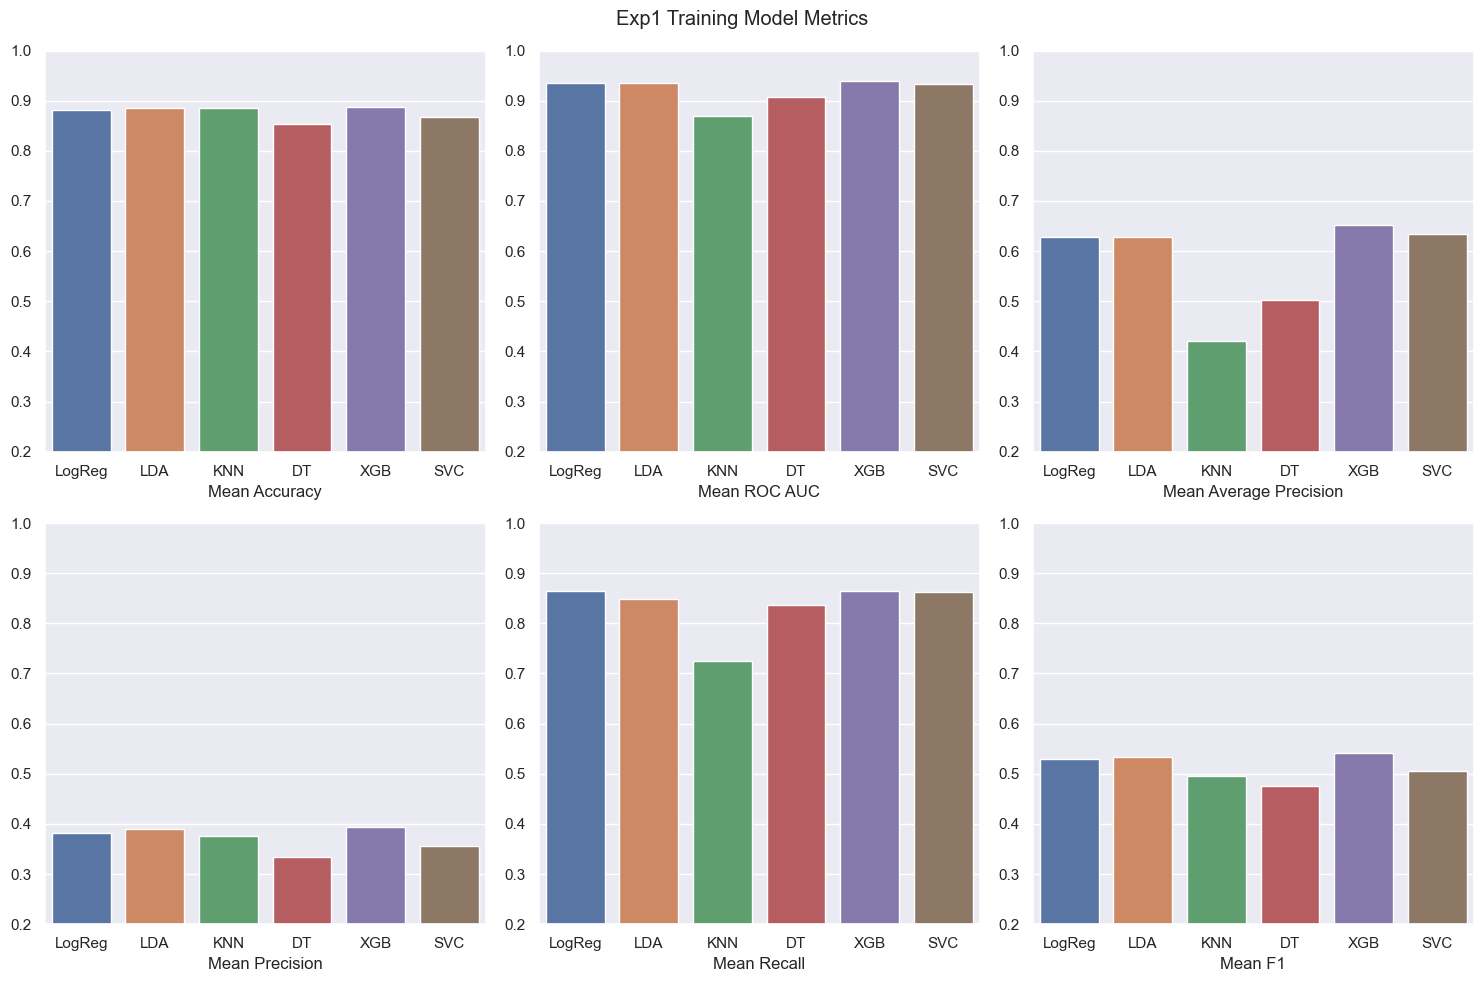

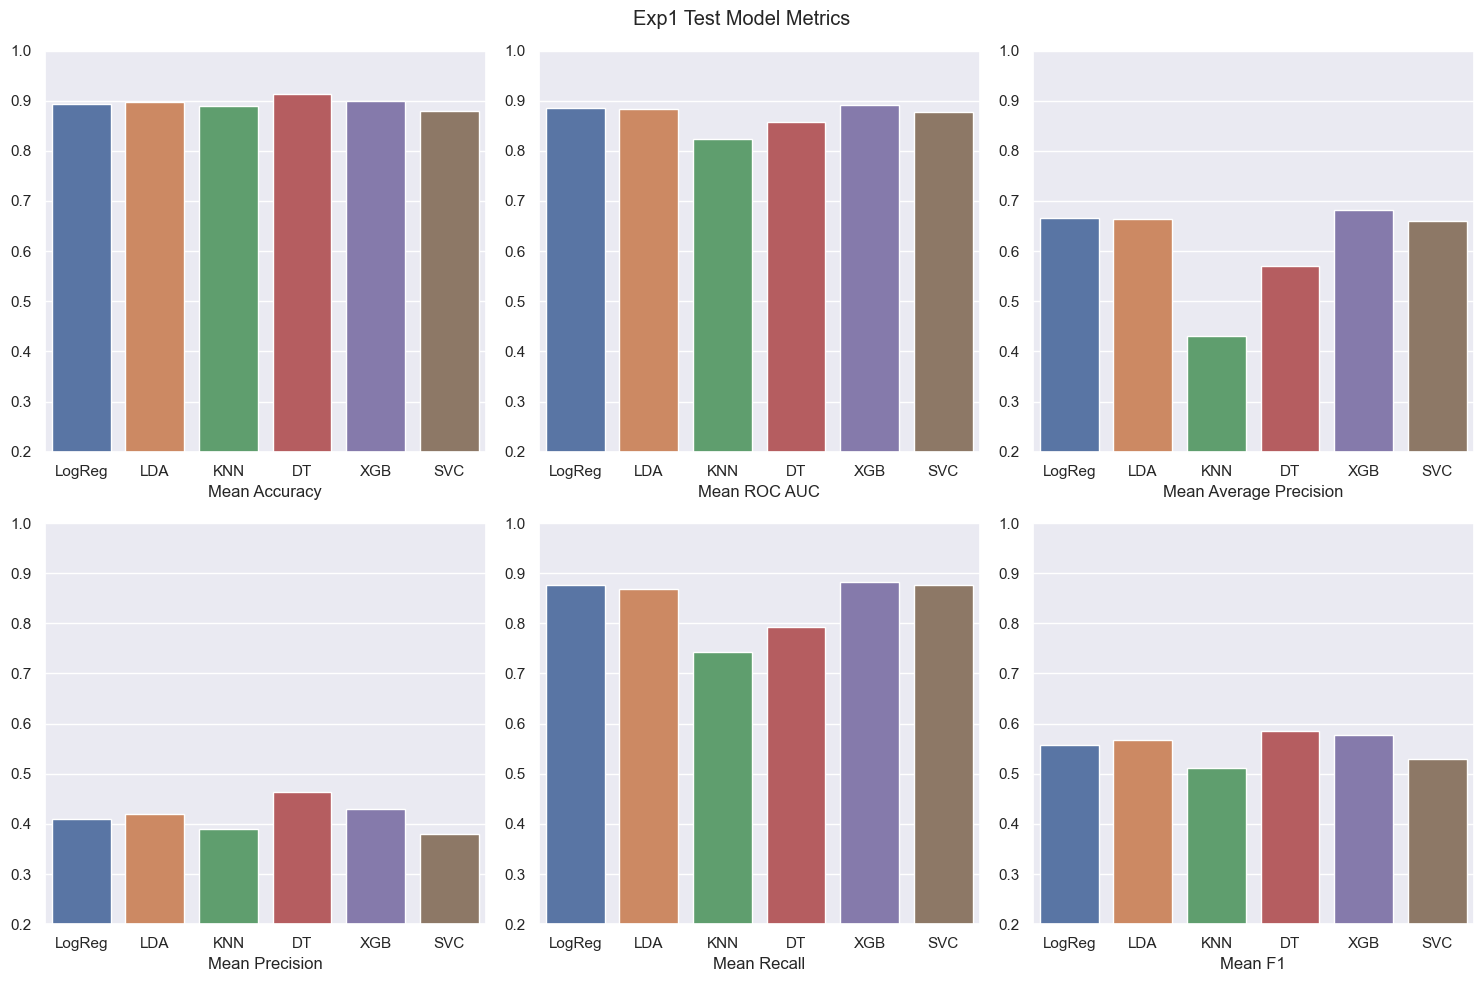

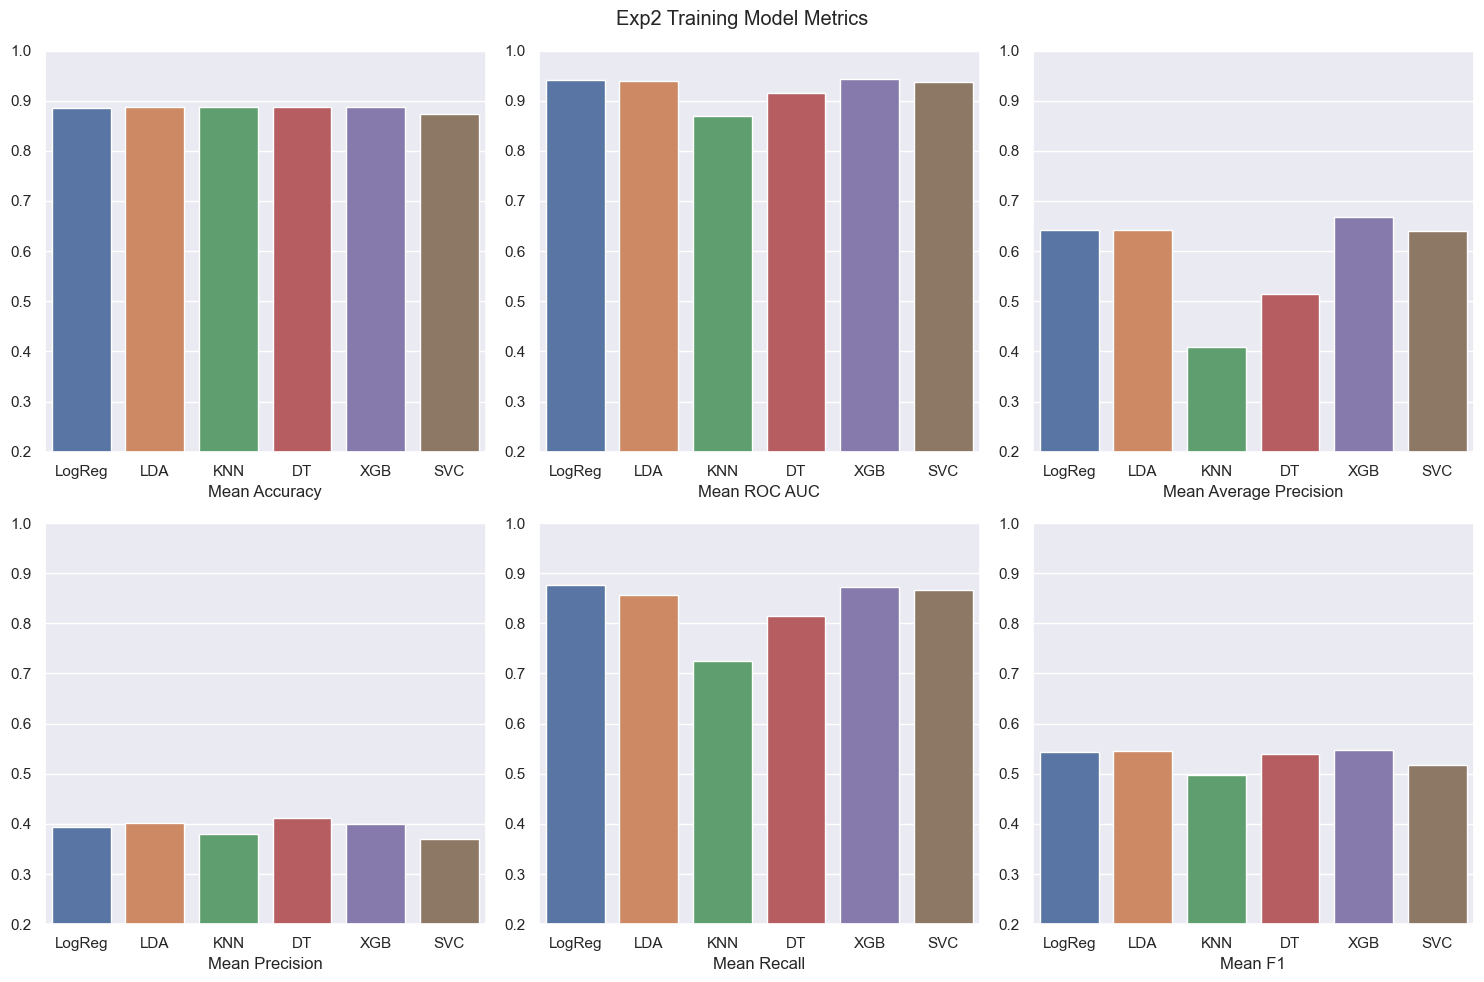

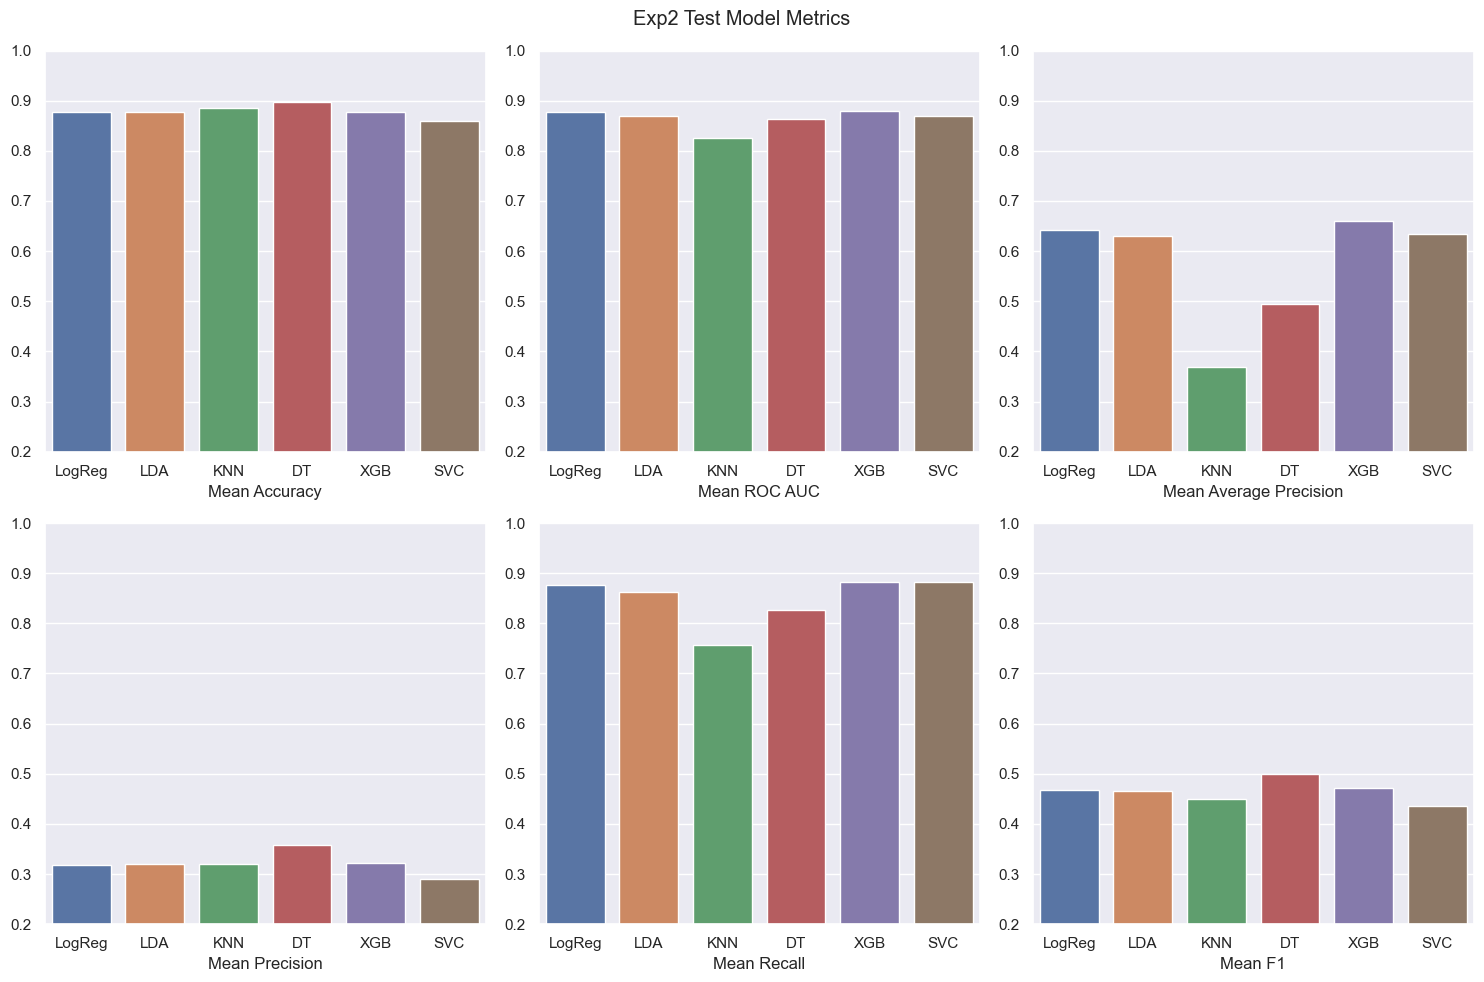

In [38]:
# Barplots of Model Results in each Phase (Baseline, Training, Test) for each Exp, for Acc / ROC AUC / PR AUC
barplot_metrics = ['Accuracy', 'ROC AUC', 'Average Precision', 'Precision', 'Recall', 'F1']

# set data, filename, and title for the barplot images
barplot_info = [
    [exp1_train_means, 'model_metrics_exp1_train', 'Exp1 Training Model Metrics'],
    [exp1_test_means, 'model_metrics_exp1_test', 'Exp1 Test Model Metrics'],
    [exp2_train_means, 'model_metrics_exp2_train', 'Exp2 Training Model Metrics'],
    [exp2_test_means, 'model_metrics_exp2_test', 'Exp2 Test Model Metrics']]

# create  a barplot for each list in barplot_info
for info in barplot_info:
    model_metric_bar_grid(data=info[0], metrics=barplot_metrics, filename=info[1], title=info[2])
    plt.show()
    

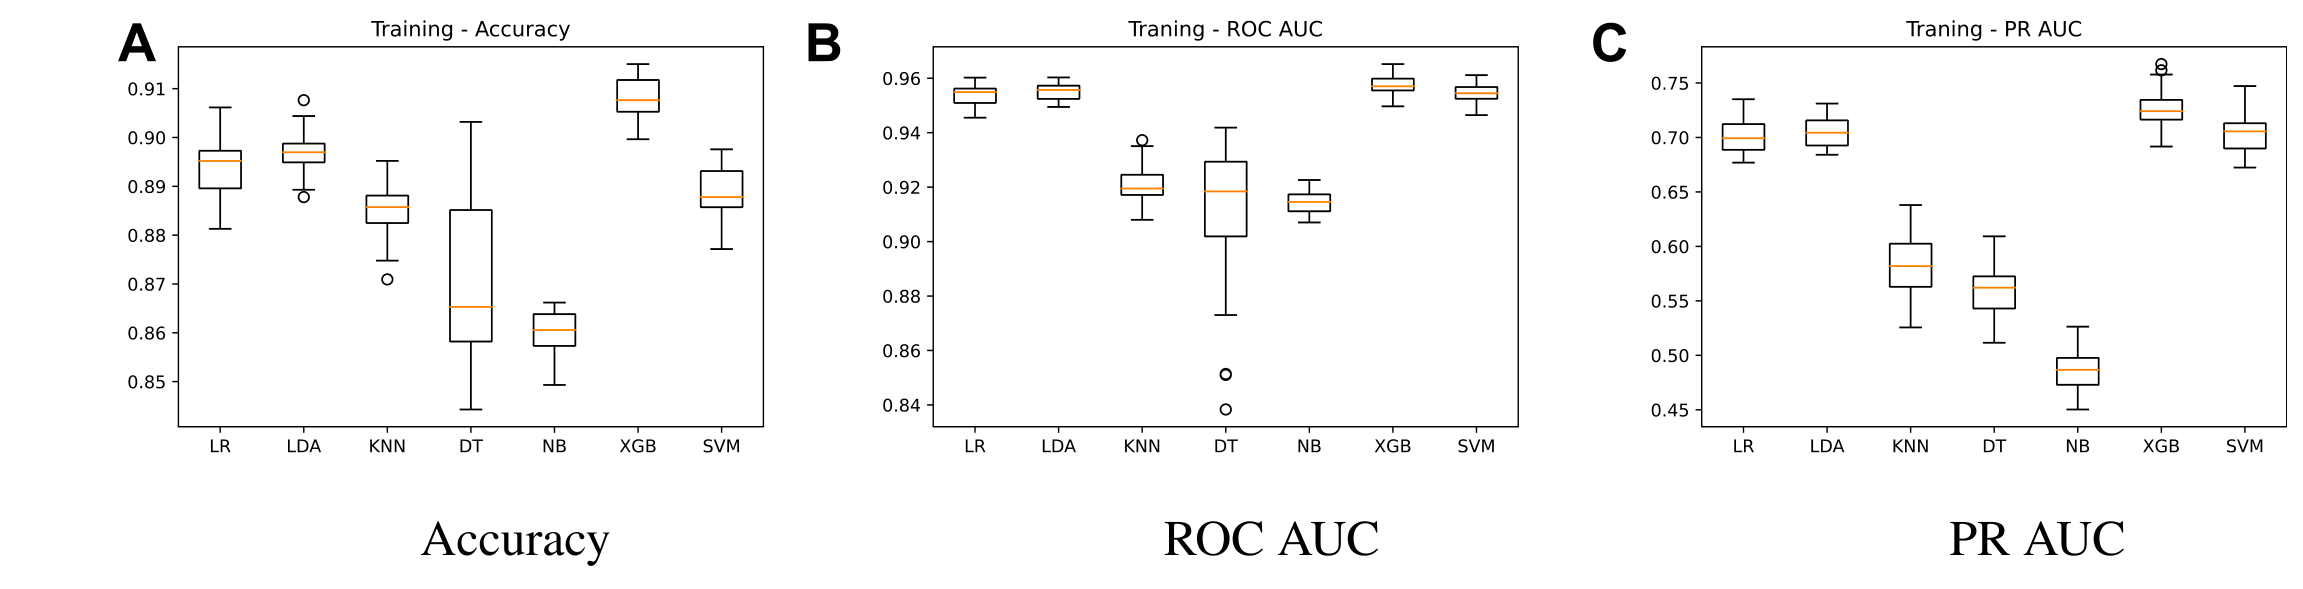

In [5]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\paper_exp1_train_results.PNG'))

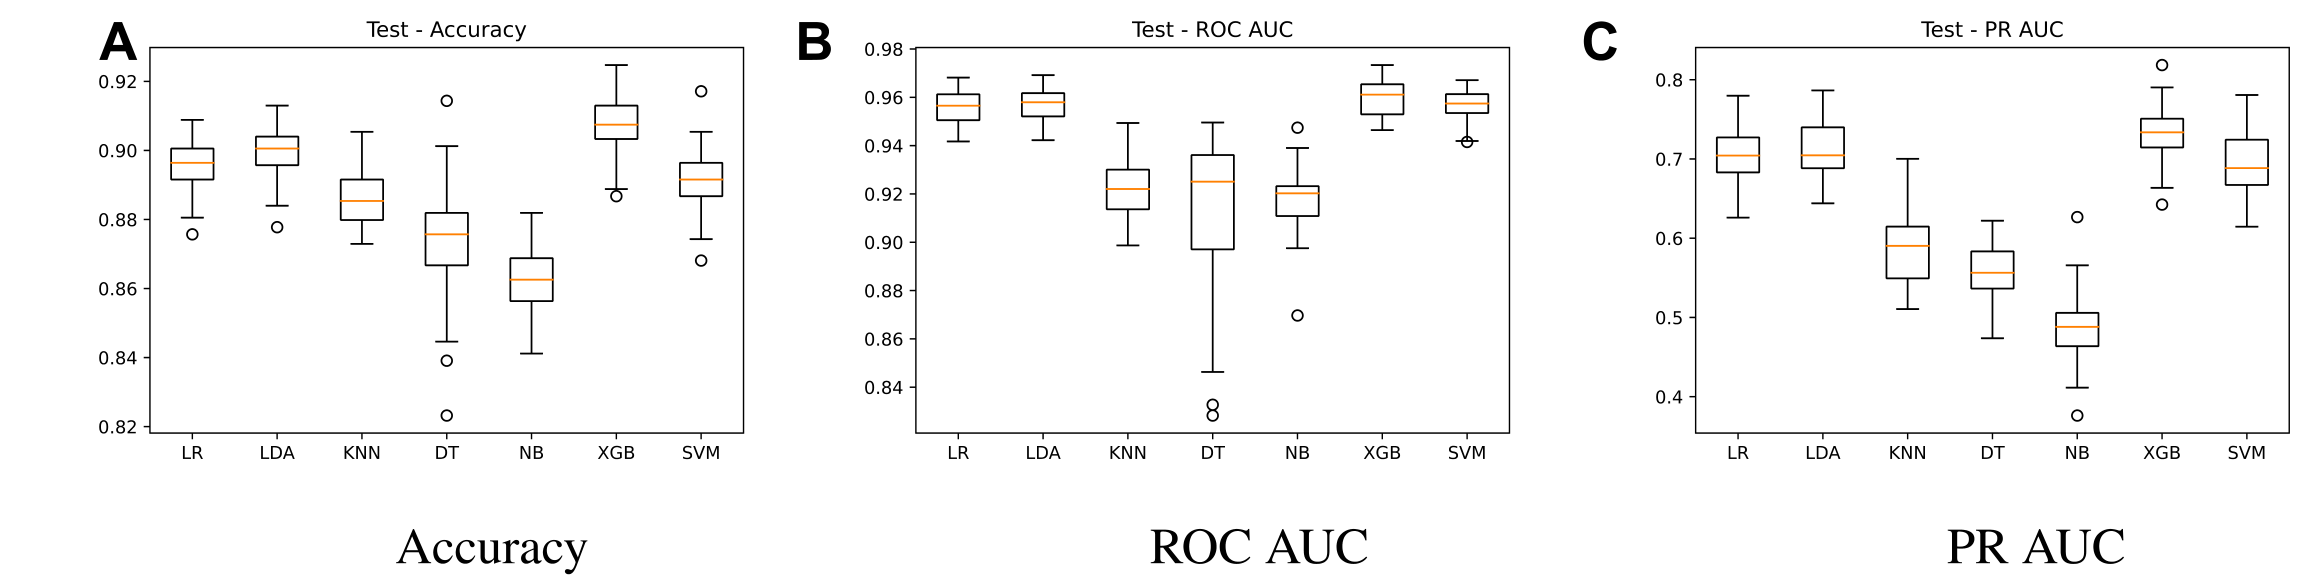

In [6]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\paper_exp1_test_results.PNG'))

In [39]:
from IPython.display import HTML
def build_comparison_tables(data):
    """Build a table showing the average values of the key metrics for each inputted model"""
    all_metrics = ['Accuracy', 'ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1']
    all_models = [type(model).__name__ for model in [d['Model'] for d in data]]
    all_acc = [d['Accuracy'] for d in data]
    all_roc = [d['ROC AUC'] for d in data]
    all_avg_prc = [d['Average Precision'] for d in data]
    all_prc = [d['Precision'] for d in data]
    all_rcl = [d['Recall'] for d in data]
    all_F1 = [d['F1'] for d in data]

    df = pd.DataFrame(data=[all_acc, all_roc, all_avg_prc, all_prc, all_rcl, all_F1], columns=all_models)

    df.insert(loc=0, column='', value=pd.Series(all_metrics))
    
    df.round(2)
    
    return HTML(pd.DataFrame.to_html(df, index=False))


In [40]:
build_comparison_tables(exp2_train_means)


,LogisticRegression,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,SVC
Accuracy,0.884650,0.888205,0.886583,0.886585,0.887207,0.874051
ROC AUC,0.940358,0.939169,0.869467,0.914405,0.943864,0.937989
PR AUC,0.642450,0.641562,0.408201,0.513804,0.667352,0.640367
Precision,0.394522,0.401583,0.380164,0.411867,0.400743,0.370356
Recall,0.876077,0.856774,0.724865,0.815019,0.872897,0.866465
F1,0.542750,0.545326,0.498078,0.540085,0.547843,0.517858


In [41]:
build_comparison_tables(exp2_test_means)


,LogisticRegression,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,SVC
Accuracy,0.876606,0.877875,0.885805,0.897700,0.877557,0.859001
ROC AUC,0.876754,0.870245,0.825373,0.864046,0.879656,0.869766
PR AUC,0.642444,0.629750,0.368381,0.493982,0.659317,0.634162
Precision,0.319030,0.319392,0.320652,0.358176,0.321495,0.289806
Recall,0.876923,0.861538,0.756410,0.825641,0.882051,0.882051
F1,0.467852,0.466019,0.450382,0.499612,0.471233,0.436271


And here are the tables of performance metrics from the paper's second experiment:

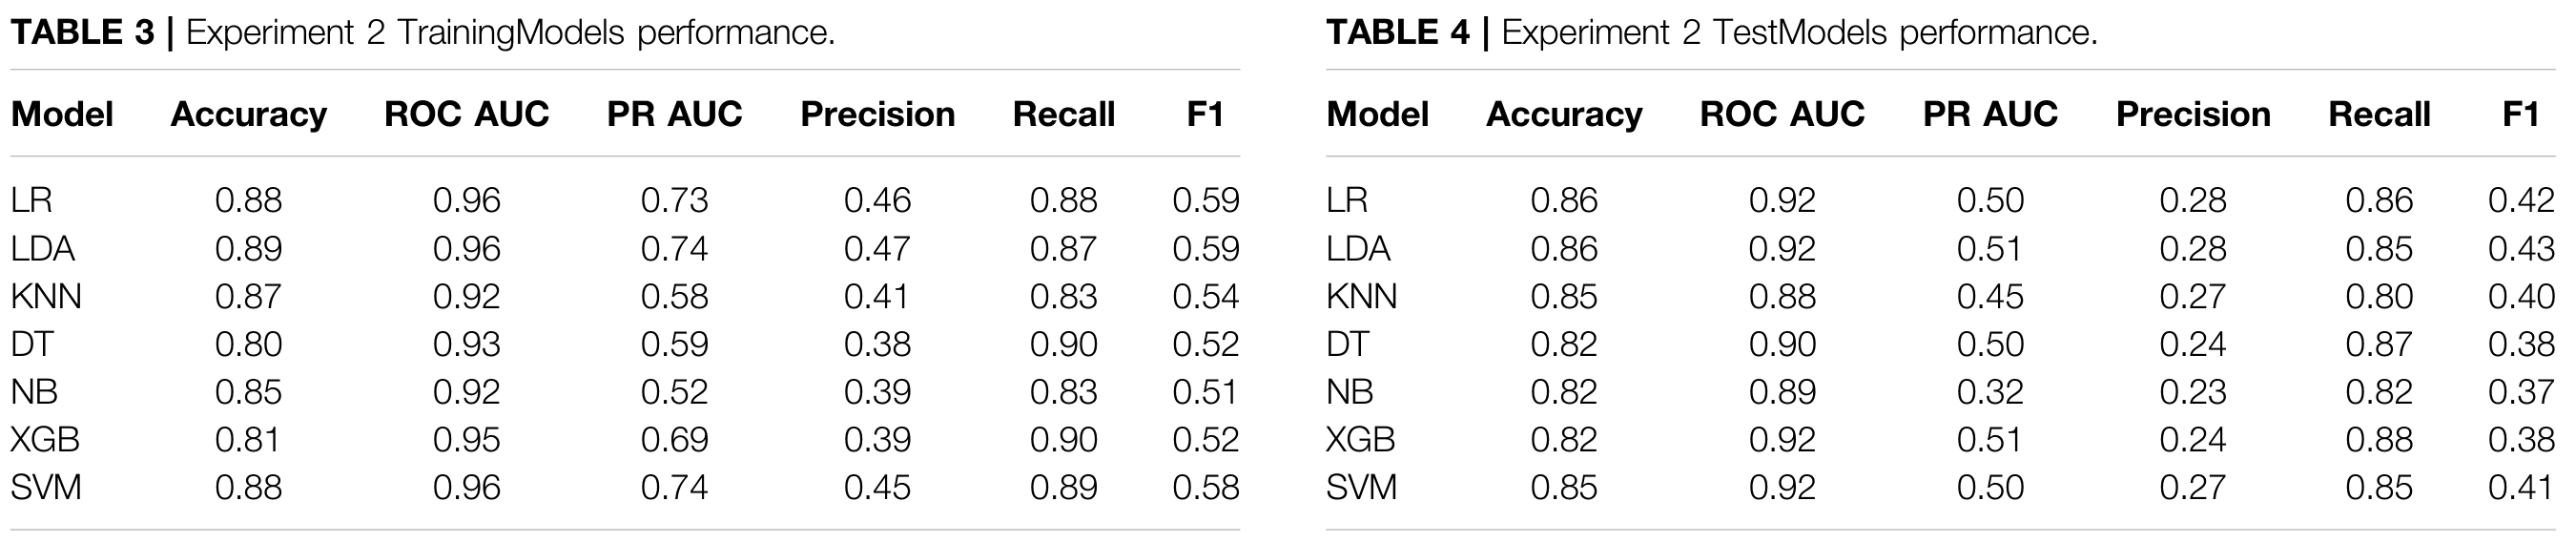

In [7]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\performance_tables_paper.PNG'))

This is the end of replicating the paper, now we explore some other ideas for improving the process used in this paper. 

But before diving in, here's a quick visualization of how the proportion of individuals who were cured vs who died changed from the first weeks of data in the dataset (2020) compared to the cases from most of 2021.

Before May 24, 2020


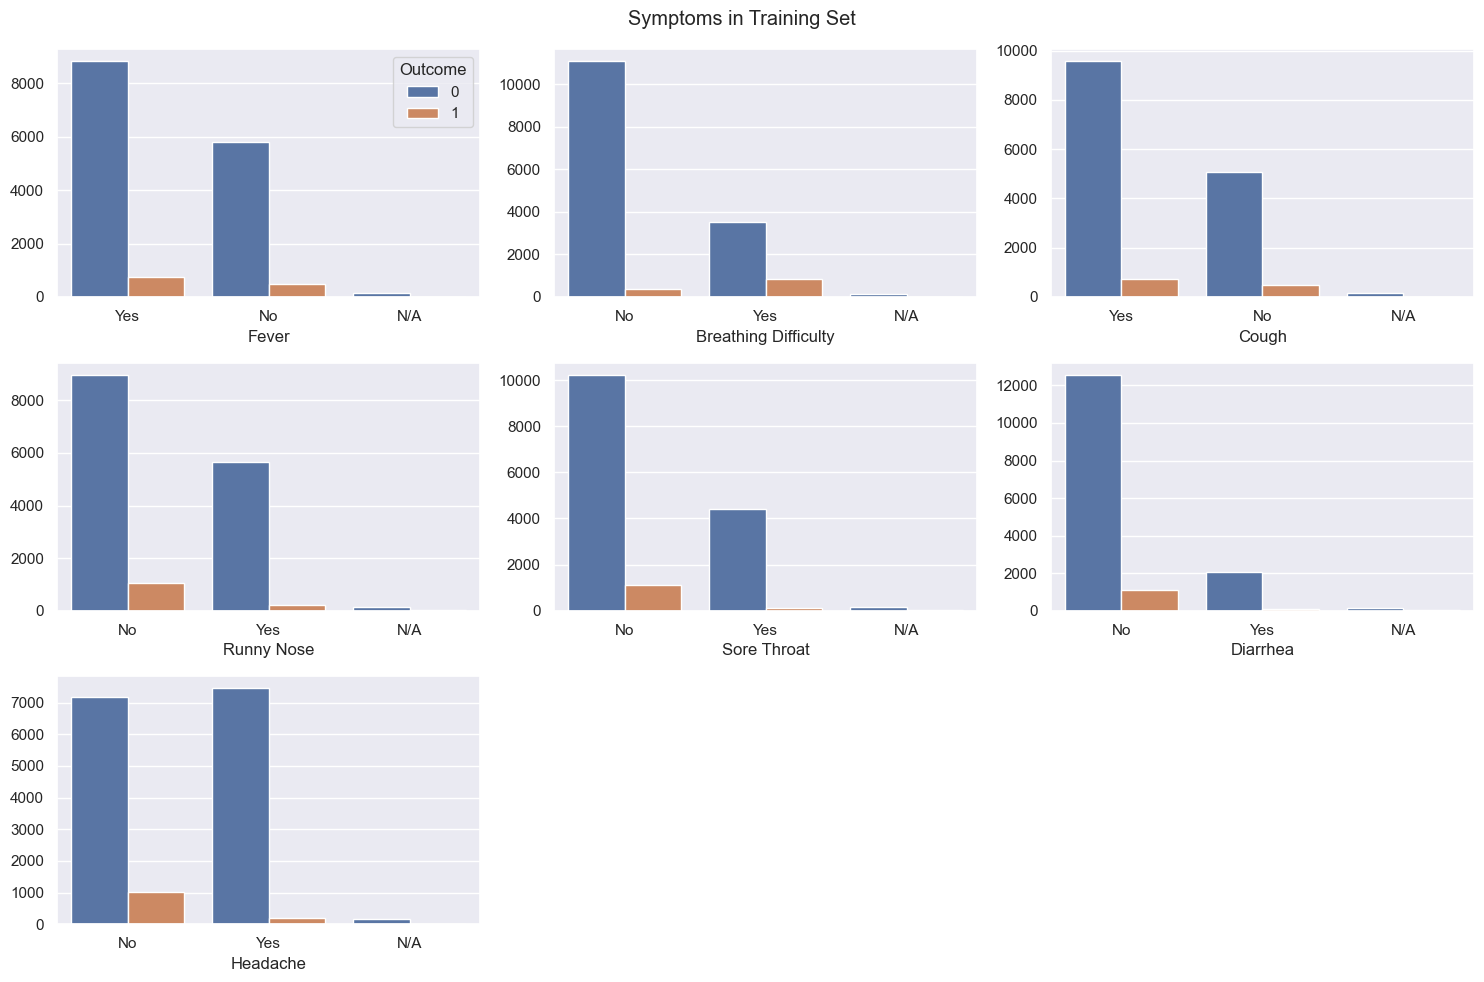

In [42]:
# Show the demographics from the Experiment 1 dataset (first weeks of the data)
data_names = ['Before May 24, 2020']
data = [pr10_exp1_df]

for data_w_name in zip(data, data_names):
    print(data_w_name[1])
    build_plot_grid(df=data_w_name[0],
                parameters=['Fever', 'BreathingDifficulty', 'Cough', 'RunnyNose', 'SoreThroat', 'Diarrhea',
                            'Headache'],
                filename=f"{data_w_name[1]}_symptoms",
                title='Symptoms in Training Set')
    plt.show()
    

2020 and 2021


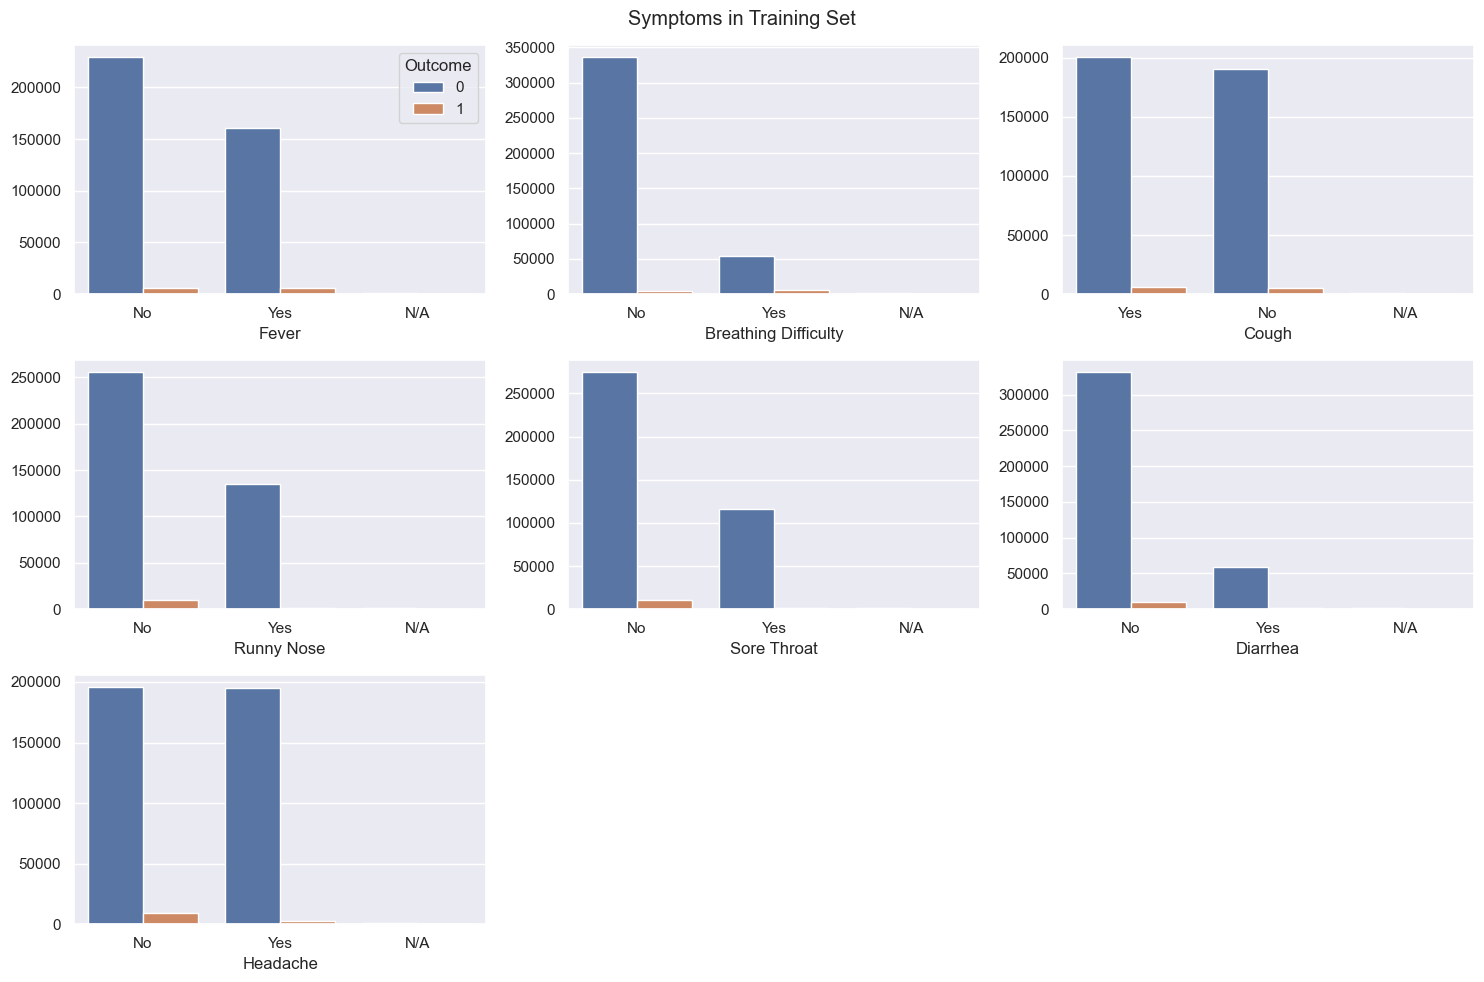

In [43]:
# show the demographics from all the data
data_names = ['2020 and 2021']
data = [all_data]

for data_w_name in zip(data, data_names):
    print(data_w_name[1])
    build_plot_grid(df=data_w_name[0],
                parameters=['Fever', 'BreathingDifficulty', 'Cough', 'RunnyNose', 'SoreThroat', 'Diarrhea',
                            'Headache'],
                filename=f"{data_w_name[1]}_symptoms",
                title='Symptoms in Training Set')
    
    plt.show()

The paper used about 25 different features to reach their results. 

My first goal was to reduce the required number of features while maintaining or improving the performance of the models.

In [44]:
#### evaluate the most important variables for the model
best_mod = xgb.XGBClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=1000,
                                  subsample=0.6)


In [45]:
def check_feature_importance(model, features, target):
    """Determine the most important feature for the given model from the given data"""
    transformer, oversampler = preprocessing_fns()

    pipeline = imblearn.pipeline.make_pipeline(transformer, oversampler, model)

    pipeline.fit(features, target)

    return pd.DataFrame(pipeline.steps[2][1].feature_importances_, pipeline.steps[0][1].get_feature_names_out())


In [46]:
pd.set_option("display.max_columns", None)    
check_feature_importance(xgb.XGBClassifier(), exp1_f_train, exp1_t_train).T


,onehotencoder__CriteriaConfirmation_Clinic,onehotencoder__CriteriaConfirmation_Epidem.,onehotencoder__CriteriaConfirmation_Lab,onehotencoder__CriteriaConfirmation_N/A,onehotencoder__Sex_F,onehotencoder__Sex_M,onehotencoder__Sex_N/A,onehotencoder__ColorRace_Black,onehotencoder__ColorRace_Brown,onehotencoder__ColorRace_Indigenous,onehotencoder__ColorRace_N/A,onehotencoder__ColorRace_White,onehotencoder__ColorRace_Yellow,onehotencoder__Education_Gr. 1,onehotencoder__Education_Gr. 4,onehotencoder__Education_HS,onehotencoder__Education_Higher Ed.,onehotencoder__Education_I Gr. 4,onehotencoder__Education_I Gr. 8,onehotencoder__Education_I HS,onehotencoder__Education_I Higher,onehotencoder__Education_N/A,onehotencoder__Education_None,onehotencoder__Fever_N/A,onehotencoder__Fever_No,onehotencoder__Fever_Yes,onehotencoder__BreathingDifficulty_N/A,onehotencoder__BreathingDifficulty_No,onehotencoder__BreathingDifficulty_Yes,onehotencoder__Cough_N/A,onehotencoder__Cough_No,onehotencoder__Cough_Yes,onehotencoder__RunnyNose_N/A,onehotencoder__RunnyNose_No,onehotencoder__RunnyNose_Yes,onehotencoder__SoreThroat_N/A,onehotencoder__SoreThroat_No,onehotencoder__SoreThroat_Yes,onehotencoder__Diarrhea_N/A,onehotencoder__Diarrhea_No,onehotencoder__Diarrhea_Yes,onehotencoder__Headache_N/A,onehotencoder__Headache_No,onehotencoder__Headache_Yes,onehotencoder__ComorbidityPulmonary_N/A,onehotencoder__ComorbidityPulmonary_No,onehotencoder__ComorbidityPulmonary_Yes,onehotencoder__ComorbidityCardiac_N/A,onehotencoder__ComorbidityCardiac_No,onehotencoder__ComorbidityCardiac_Yes,onehotencoder__ComorbidityRenal_N/A,onehotencoder__ComorbidityRenal_No,onehotencoder__ComorbidityRenal_Yes,onehotencoder__ComorbidityDiabetes_N/A,onehotencoder__ComorbidityDiabetes_No,onehotencoder__ComorbidityDiabetes_Yes,onehotencoder__ComorbiditySmoking_N/A,onehotencoder__ComorbiditySmoking_No,onehotencoder__ComorbiditySmoking_Yes,onehotencoder__ComorbidityObesity_N/A,onehotencoder__ComorbidityObesity_No,onehotencoder__ComorbidityObesity_Yes,onehotencoder__Hospitalized_N/A,onehotencoder__Hospitalized_No,onehotencoder__Hospitalized_Yes,onehotencoder__TravelBrasil_N/A,onehotencoder__TravelBrasil_No,onehotencoder__TravelBrasil_Yes,onehotencoder__TravelInternational_N/A,onehotencoder__TravelInternational_No,onehotencoder__TravelInternational_Yes,onehotencoder__OverSixty_No,onehotencoder__OverSixty_Yes,ordinalencoder__AgeGroup,ordinalencoder__SumComorbidities,ordinalencoder__SumSymptoms
0,0.007444,0.013044,0.01514,0.0,0.008827,0.004564,0.0,0.005571,0.00413,0.006911,0.008292,0.006718,0.006877,0.01012,0.004698,0.012378,0.028323,0.005916,0.009476,0.00857,0.010163,0.006534,0.004718,0.002457,0.006058,0.009725,0.005799,0.004863,0.051923,0.00115,0.008608,0.008091,0.008945,0.008719,0.015379,0.000569,0.013143,0.024624,0.0,0.010323,0.009934,0.002191,0.014566,0.021677,0.0,0.004813,0.009374,0.001358,0.008377,0.007287,0.004084,0.006869,0.010232,0.0,0.006773,0.015863,0.001426,0.010687,0.009136,0.0065,0.009836,0.006953,0.009953,0.009329,0.15375,0.007693,0.009063,0.008315,0.007638,0.012136,0.005172,0.180399,0.0,0.042767,0.008199,0.008858


From the above results, I decided to keep the following features and remove the rest:
- Hospitalization
- Age Group
- Over60
- Sum of Symptoms
- Sum of Comorbidities
- Breathing Difficulty
- Sore Throat
- Headache
- Education

In [47]:
# remove the columns -- keep only above features
focused_exp1 = pr10_exp1_df.copy()
focused_exp2 = pr10_exp2_df.copy()
for df in focused_exp1, focused_exp2:
    df.drop(columns=['CriteriaConfirmation', 'Sex', 'ColorRace', 'Fever', 'Cough', 'RunnyNose', 'Diarrhea',
                     'ComorbidityPulmonary', 'ComorbidityCardiac', 'ComorbidityRenal',
                     'ComorbiditySmoking', 'ComorbidityObesity', 'TravelBrasil', 'TravelInternational'],
            inplace=True)

In [48]:
focused_f_train = focused_exp1.iloc[:, 1:]
focused_t_train = focused_exp1.iloc[:, 0]
focused_f_test = focused_exp2.iloc[:, 1:]
focused_t_test = focused_exp2.iloc[:, 0]

In [49]:
focused_dfs = run_exp([best_mod],
                      focused_f_train, focused_t_train, focused_f_test, focused_t_test,
                      evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'], rpt=1,
                      focused=True)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) results done
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=

In [50]:
def focused_preprocessing_fns():
    """Prepare data given the 'focused' data, with reduced features"""
    categorical_encoder = skl.preprocessing.OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    agegroup_levels = ['0-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
    sumcom_levels = [0, 1, 2, 3, 4, 5, 6]
    sumsym_levels = [0, 1, 2, 3, 4, 5, 6, 7]

    ordinal_encoder = skl.preprocessing.OrdinalEncoder(handle_unknown='use_encoded_value',
                                                       unknown_value=-1,
                                                       categories=[agegroup_levels, sumcom_levels, sumsym_levels])

    categorical_fts = ['Education', 'BreathingDifficulty', 'SoreThroat', 'Headache', 'ComorbidityDiabetes',
                       'Hospitalized', 'OverSixty']
    ordinal_fts = ['AgeGroup', 'SumComorbidities', 'SumSymptoms']
    transformer = sklcmp.make_column_transformer((categorical_encoder, categorical_fts),
                                                 (ordinal_encoder, ordinal_fts))

    oversampler = imbovr.RandomOverSampler(sampling_strategy=1)

    return transformer, oversampler

In [51]:
# Get means of test results for each run
focused_train_means, focused_test_means = mc.lists_of_runs_to_lists_of_model_means(focused_dfs)

In [52]:
# create correct data format for confusion matrices
focused_models, focused_real_and_preds = vis.create_confusion_matrix_info(focused_test_means)

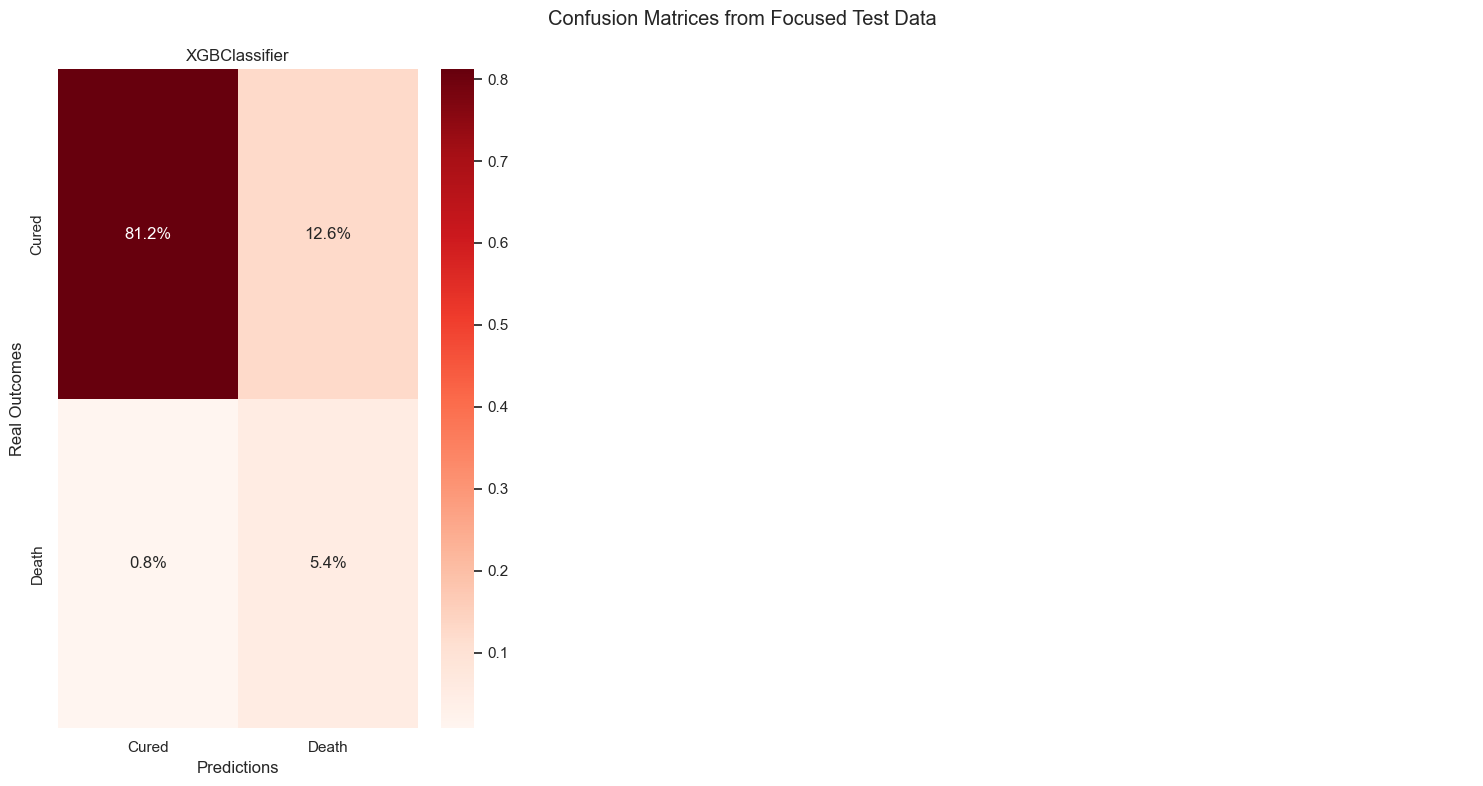

In [53]:
# create confusion matrices
build_conf_mtrx_grid(focused_models, focused_real_and_preds,
                         filename='conf_mtrx_focused_test',
                         title='Confusion Matrices from Focused Test Data')

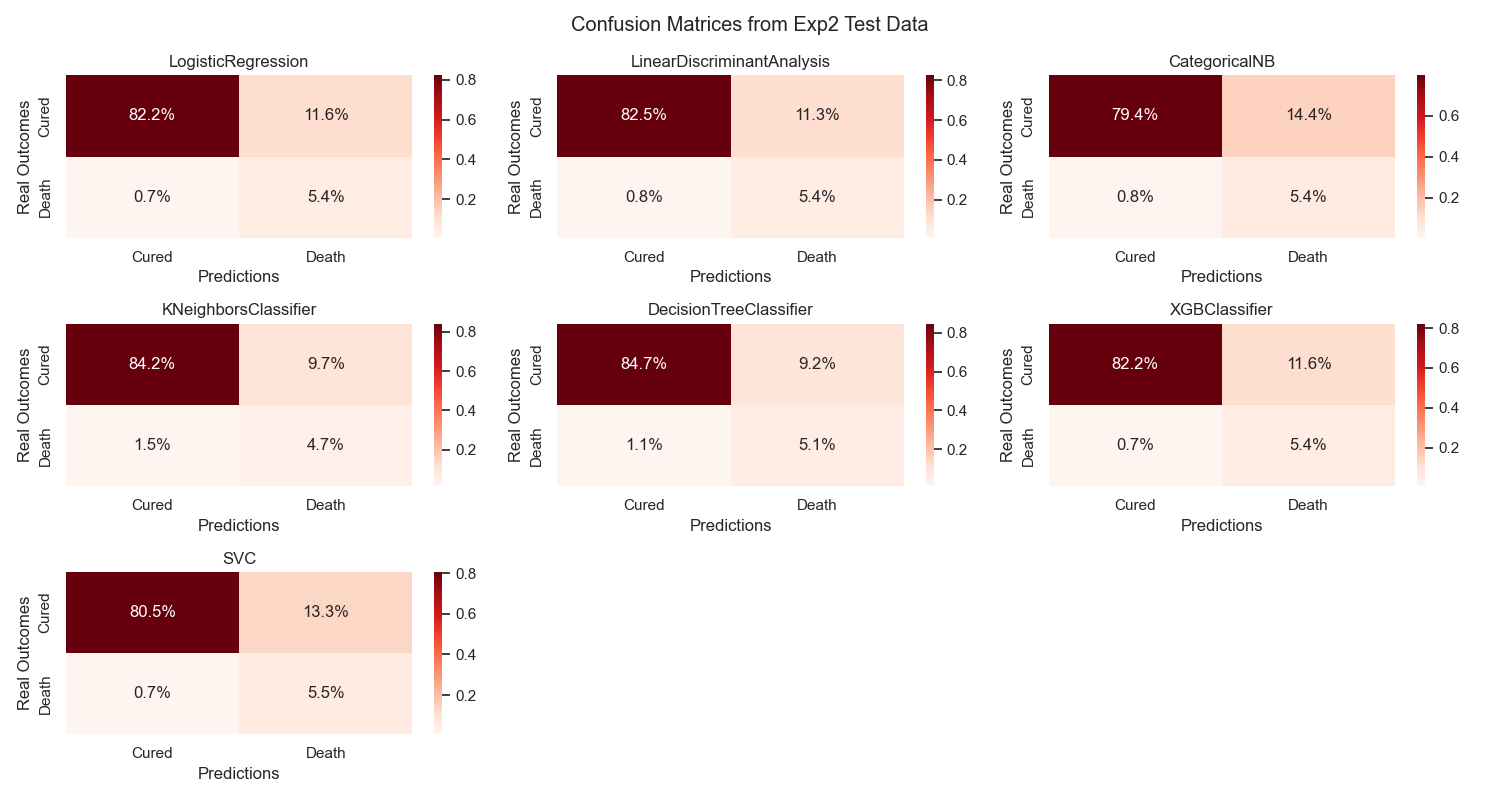

In [8]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\conf_mtrx_exp2_test.PNG'))

In [54]:
build_comparison_tables(focused_test_means)


,XGBClassifier
Accuracy,0.865979
ROC AUC,0.869893
PR AUC,0.630054
Precision,0.299912
Recall,0.874359
F1,0.446627


In [55]:
build_comparison_tables(exp2_test_means)


,LogisticRegression,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,SVC
Accuracy,0.876606,0.877875,0.885805,0.897700,0.877557,0.859001
ROC AUC,0.876754,0.870245,0.825373,0.864046,0.879656,0.869766
PR AUC,0.642444,0.629750,0.368381,0.493982,0.659317,0.634162
Precision,0.319030,0.319392,0.320652,0.358176,0.321495,0.289806
Recall,0.876923,0.861538,0.756410,0.825641,0.882051,0.882051
F1,0.467852,0.466019,0.450382,0.499612,0.471233,0.436271


The next goal was to use the most effective model from Experiment 1 and 2, train it on all the Exp1+2 data (before June 2020), and test it on data from 2021 to evaluate the effectiveness of the model with a larger dataset from further into the future.

In [56]:
train_pre_2020_june = all_data[
    (all_data['NotificationDate'] < "2020-06-01")].copy()
test_recent = all_data[
    (all_data['NotificationDate'] > "2020-12-31")].copy()

for df in train_pre_2020_june, test_recent:
    del df['NotificationDate']
    
train_pre_2020_june_f = train_pre_2020_june.iloc[:, 1:]
train_pre_2020_june_t = train_pre_2020_june.iloc[:, 0]
test_recent_f = test_recent.iloc[:, 1:]
test_recent_t = test_recent.iloc[:, 0]


In [57]:
recent_dfs = run_exp([best_mod],
                     train_pre_2020_june_f,
                     train_pre_2020_june_t,
                     test_recent_f,
                     test_recent_t,
                     evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
                     rpt=1)

# Get means of test results for each run
train_pre_2020_june_means, test_recent_means = mc.lists_of_runs_to_lists_of_model_means(recent_dfs)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) results done
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=

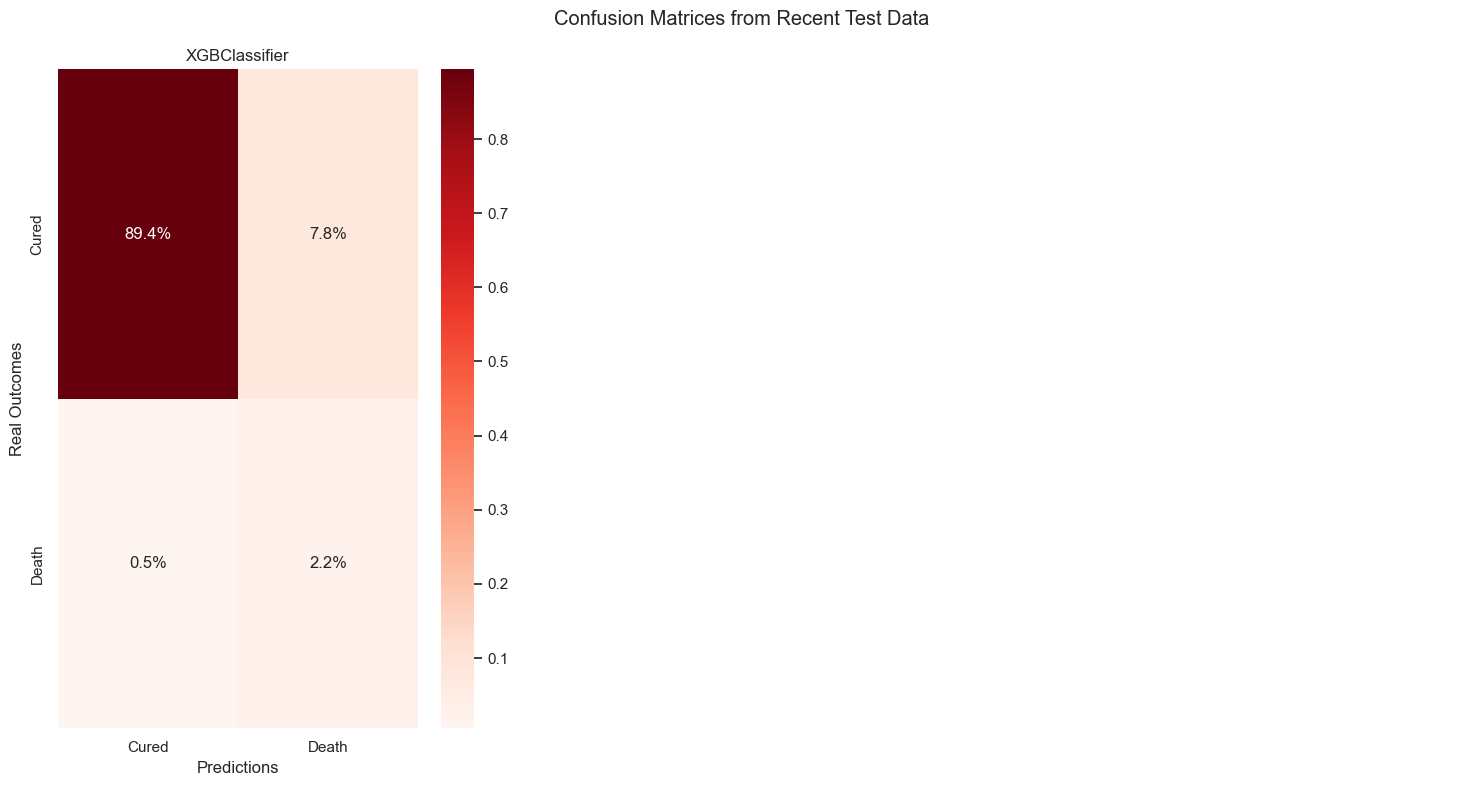

In [58]:
# create correct data format for confusion matrices
recent_data_models, recent_data_real_and_preds = vis.create_confusion_matrix_info(test_recent_means)

# create confusion matrices
build_conf_mtrx_grid(recent_data_models, recent_data_real_and_preds,
                         filename='conf_mtrx_recent_test',
                         title='Confusion Matrices from Recent Test Data')


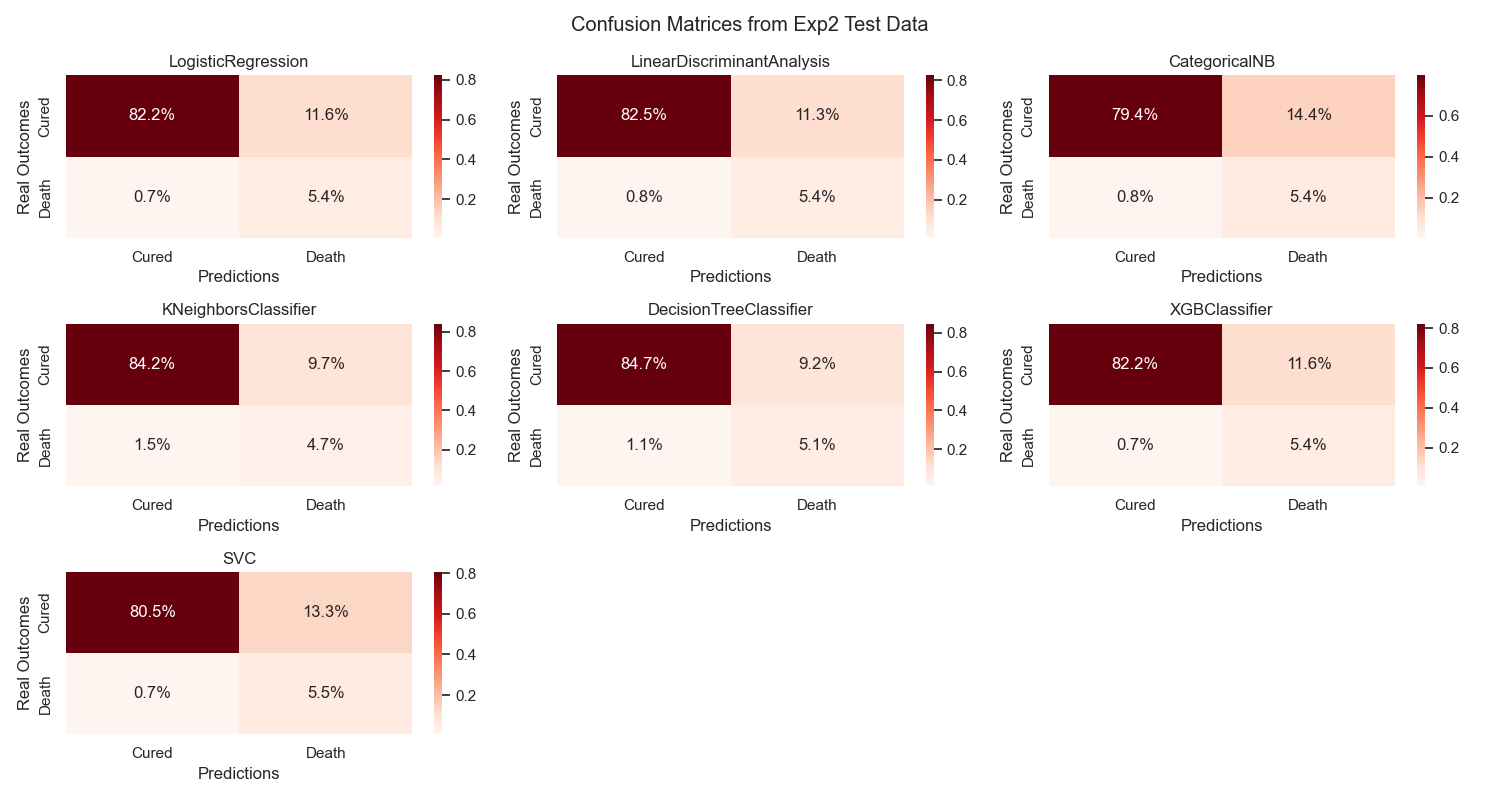

In [9]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\conf_mtrx_exp2_test.PNG'))

In [59]:
build_comparison_tables(test_recent_means)


,XGBClassifier
Accuracy,0.916253
ROC AUC,0.862625
PR AUC,0.478460
Precision,0.221014
Recall,0.805865
F1,0.346891


In [60]:
build_comparison_tables(exp2_test_means)


,LogisticRegression,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,SVC
Accuracy,0.876606,0.877875,0.885805,0.897700,0.877557,0.859001
ROC AUC,0.876754,0.870245,0.825373,0.864046,0.879656,0.869766
PR AUC,0.642444,0.629750,0.368381,0.493982,0.659317,0.634162
Precision,0.319030,0.319392,0.320652,0.358176,0.321495,0.289806
Recall,0.876923,0.861538,0.756410,0.825641,0.882051,0.882051
F1,0.467852,0.466019,0.450382,0.499612,0.471233,0.436271


My next idea to improve performance was via ensemble learning with all the models.

In [61]:
#### implement ensemble learning -- Voting Classifier -- with the 7 models from the paper
import sklearn.ensemble as sklen

voting = sklen.VotingClassifier(estimators=
                                [('LR', lm.LogisticRegression(max_iter=1500, C=3.0,
                                                              fit_intercept=True, tol=1e-05)),
                                 ('LDA', da.LinearDiscriminantAnalysis(store_covariance=True)),
                                 ('KNN', nbr.KNeighborsClassifier(algorithm='kd_tree', leaf_size=10,
                                                                  n_neighbors=10, p=1)),
                                 ('XGB', xgb.XGBClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=3,
                                                           n_estimators=1000, subsample=0.6)),
                                 ('DT', tree.DecisionTreeClassifier(max_features=None, max_leaf_nodes=10,
                                                                    class_weight='balanced',
                                                                    criterion='log_loss', min_samples_leaf=3)),
                                 ('SVC', svm.SVC(kernel='rbf', C=10, gamma=0.0001, probability=True))],
                                voting='soft')


In [62]:
voting_dfs = run_exp([voting],
                     exp2_f_train,
                     exp2_t_train,
                     exp2_f_test,
                     exp2_t_test,
                     evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
                     rpt=1)

# Get means of test results for each run
voting_train_means, voting_test_means = mc.lists_of_runs_to_lists_of_model_means(voting_dfs)


VotingClassifier(estimators=[('LR',
                              LogisticRegression(C=3.0, max_iter=1500,
                                                 tol=1e-05)),
                             ('LDA',
                              LinearDiscriminantAnalysis(store_covariance=True)),
                             ('KNN',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   leaf_size=10, n_neighbors=10,
                                                   p=1)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytr...
                                            max_delta_step=None, max_depth=3,
                 

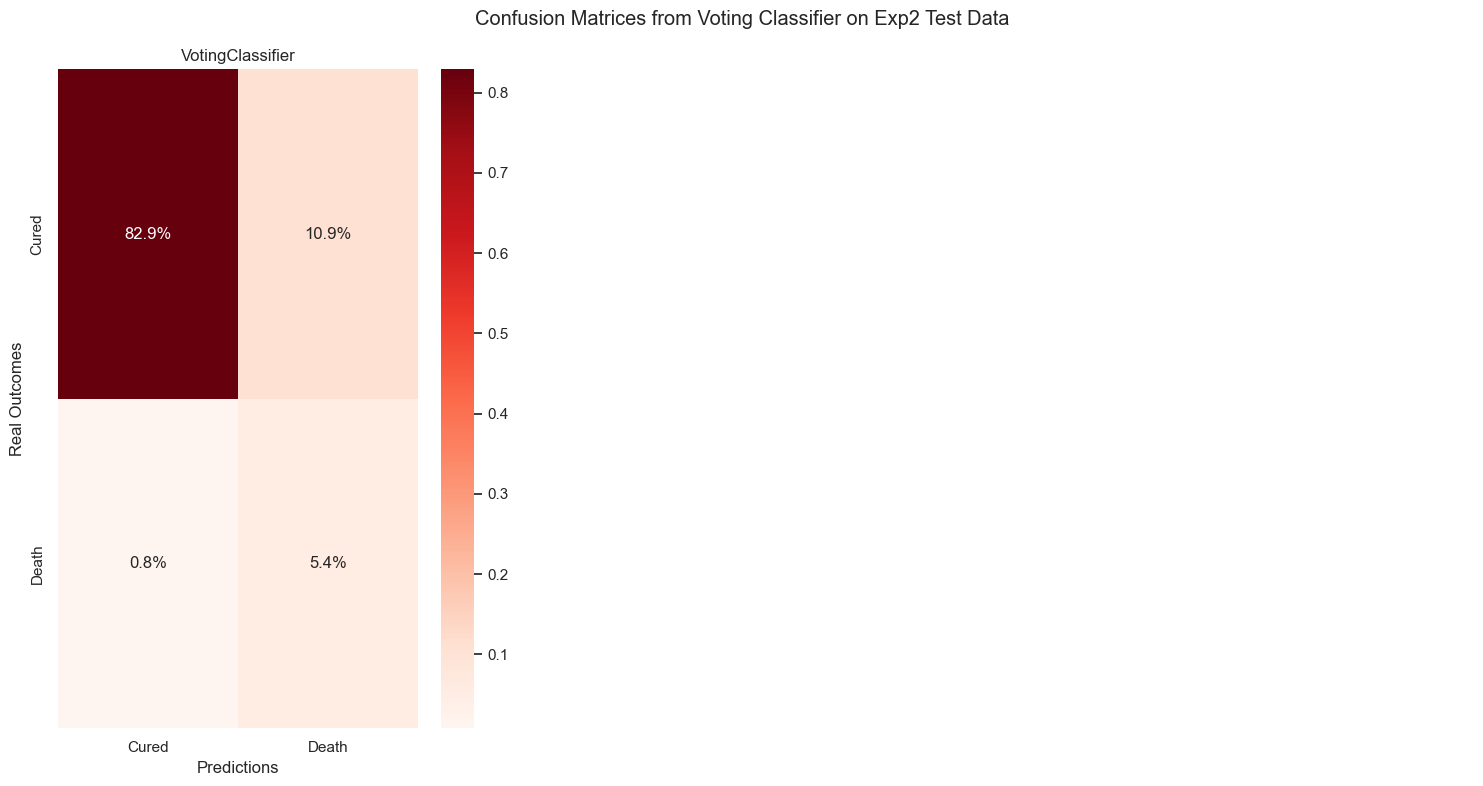

In [63]:
# create correct data format for confusion matrices
voting_models, voting_real_and_preds = vis.create_confusion_matrix_info(voting_test_means)

# create confusion matrices
build_conf_mtrx_grid(voting_models, voting_real_and_preds,
                         filename='conf_mtrx_voting_test',
                         title='Confusion Matrices from Voting Classifier on Exp2 Test Data')


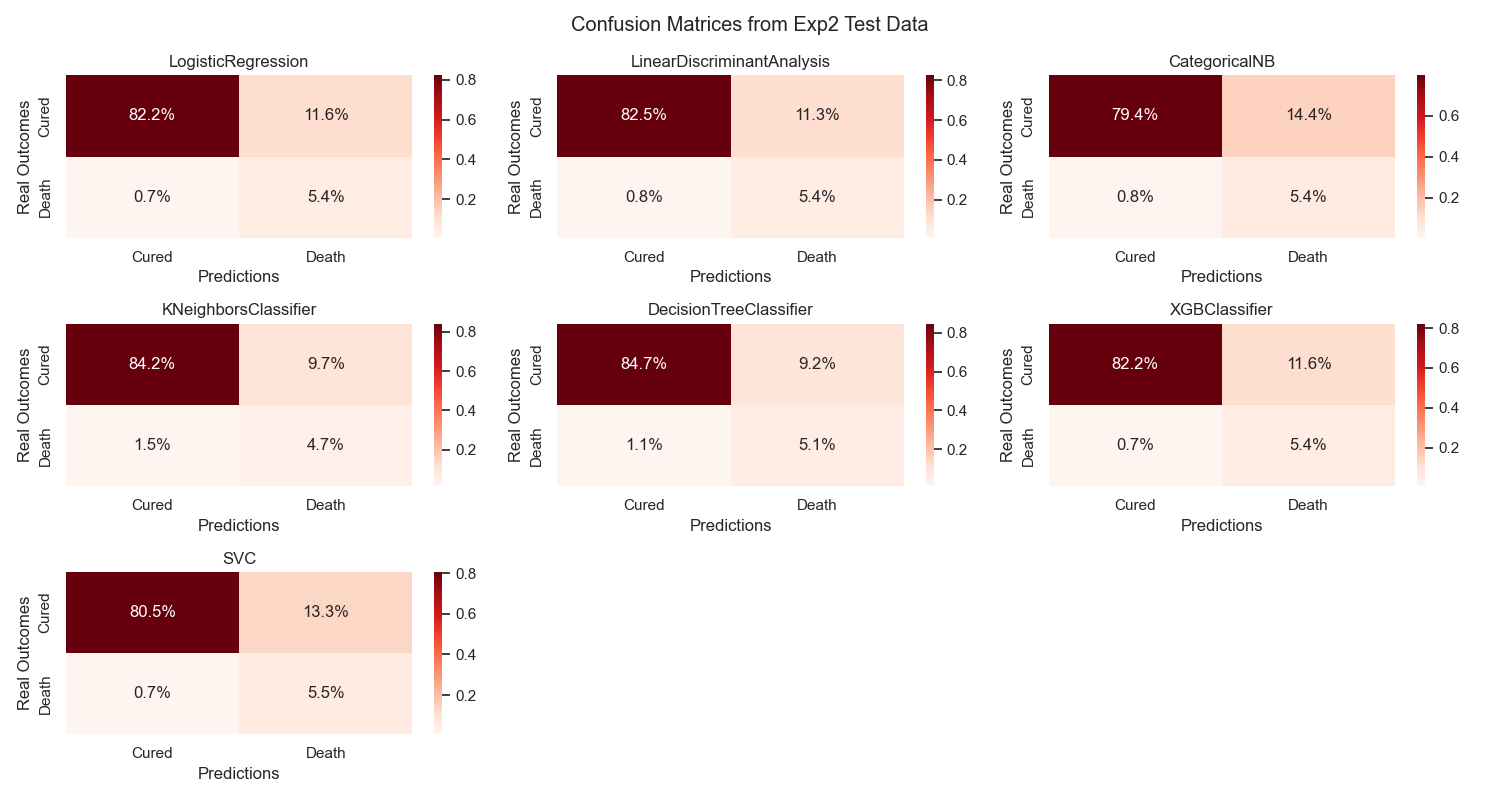

In [10]:
display(Image(filename=f'{os.path.dirname(os.getcwd())}\\figures\\conf_mtrx_exp2_test.PNG'))

In [64]:
build_comparison_tables(voting_test_means)


,VotingClassifier
Accuracy,0.882633
ROC AUC,0.876374
PR AUC,0.631160
Precision,0.329767
Recall,0.869231
F1,0.478138


In [65]:
build_comparison_tables(exp2_test_means)


,LogisticRegression,LinearDiscriminantAnalysis,KNeighborsClassifier,DecisionTreeClassifier,XGBClassifier,SVC
Accuracy,0.876606,0.877875,0.885805,0.897700,0.877557,0.859001
ROC AUC,0.876754,0.870245,0.825373,0.864046,0.879656,0.869766
PR AUC,0.642444,0.629750,0.368381,0.493982,0.659317,0.634162
Precision,0.319030,0.319392,0.320652,0.358176,0.321495,0.289806
Recall,0.876923,0.861538,0.756410,0.825641,0.882051,0.882051
F1,0.467852,0.466019,0.450382,0.499612,0.471233,0.436271


Training, testing, building, and in general running the experiments took a long time on my computer -- specifically, an extensive grid search (once for each model) and running Experiment 1 fully (33x) each needed to run overnight to complete.

I researched solutions and stumbled upon a brilliant library -- sklearnex, built by and for Intel processors. A brief example of the speed performance is shown below, and I have found the speed improvement increases with the size of the dataset and the number of repetitions.

The time difference may not be apparent based on the device used to run this section. With my i7 processor, I saved (on average) ~30% of the time running an experiment with two repetitions using a Logistic Regression model. The time varies based on the model, and not all models are optimized (for example, XGBoost is not part of sklearn and therefore is not optimized).

In [66]:
# compare times to complete for the above task with and without sklearnex
# XGBoost isn't affected, so test with LogisticRegression and KNN
import time

patched_start = time.time()
run_exp([lm.LogisticRegression(max_iter=1500, C=3.0, fit_intercept=True, tol=1e-05)],
        train_pre_2020_june_f, train_pre_2020_june_t, test_recent_f, test_recent_t,
        evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
        rpt=1)
patched_end = time.time() - patched_start

print(patched_end)


LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) results done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) predicts done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) is completed
Round 1 completed
61.724626302719116


In [67]:
sklearnex.unpatch_sklearn()
from sklearn.linear_model import LogisticRegression

unpatched_start = time.time()
run_exp([LogisticRegression(max_iter=1500, C=3.0, fit_intercept=True, tol=1e-05)],
        train_pre_2020_june_f, train_pre_2020_june_t, test_recent_f, test_recent_t,
        evals=['accuracy', 'roc_auc', 'average_precision', 'precision', 'recall', 'f1'],
        rpt=1)
unpatched_end = time.time() - unpatched_start

print(unpatched_end)


LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) results done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) predicts done
LogisticRegression(C=3.0, max_iter=1500, tol=1e-05) is completed
Round 1 completed
98.0046157836914


In [68]:
print(f'Train Data # of rows = {len(train_pre_2020_june_f.index)}\n'
      f'Test Data # of rows = {len(test_recent_f.index)}\n'
      f'Seconds Taken for Normal Sklearn Model: {unpatched_end}\n'
      f'Seconds Taken for Sklearnex Model: {patched_end}\n'
      f'% of Time Saved: {round((1-(patched_end / unpatched_end))*100)}%')


Train Data # of rows = 22344
Test Data # of rows = 133449
Seconds Taken for Normal Sklearn Model: 98.0046157836914
Seconds Taken for Sklearnex Model: 61.724626302719116
% of Time Saved: 37%


In case the speed difference can't be seen on the processors used to run this notebook, I've uploaded a sped up video testing Logistic Regression 2x on a dataset with over 150,000 rows to show the speed improvement.

https://www.youtube.com/embed/kFsFhcGfpdI